# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [979]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [980]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [981]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-06-17 23:43:37.277143
metric: deaths at 2020-06-17 23:43:38.900840
Latest data from 2020-06-17


In [982]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [983]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-17              US    2163290          25559  117717         754   
1  2020-06-17          Brazil     955377          32188   46510        1269   
2  2020-06-17  United Kingdom     300717           1117   42238         184   
3  2020-06-17           Italy     237828            328   34448          43   
4  2020-06-17          France     194805            458   29578          28   
5  2020-06-17           Spain     244683            355   27136           0   
6  2020-06-17          Mexico     159793           4930   19080         770   
7  2020-06-17           India     366946          12881   12237         334   
8  2020-06-17         Belgium      60244             89    9675          12   
9  2020-06-17            Iran     195051           2612    9185         120   
10 2020-06-17         Germany     188604            352    8851          31   
11 2020-06-17          Canada     101491            404    8312          41   
12 2020-06-17          Russia     552549           7824    7468         194   
13 2020-06-17            Peru     240908           3752    7257         201   
14 2020-06-17     Netherlands      49412            117    6093           4   
15 2020-06-17          Sweden      54562           1239    5041         102   
16 2020-06-17          Turkey     182727           1429    4861          19   
17 2020-06-17           China      84458             36    4638           0   
18 2020-06-17         Ecuador      48490            547    4007          37   
19 2020-06-17           Chile     220628          36179    3615         232   

    mortality_rate  
0         0.054416  
1         0.048682  
2         0.140458  
3         0.144844  
4         0.151834  
5         0.110903  
6         0.119404  
7         0.033348  
8         0.160597  
9         0.047090  
10        0.046929  
11        0.081899  
12        0.013516  
13        0.030124  
14        0.123310  
15        0.092390  
16        0.026603  
17        0.054915  
18        0.082636  
19        0.016385

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [984]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
19 2020-06-17         Chile     220628          36179    3615         232   
1  2020-06-17        Brazil     955377          32188   46510        1269   
0  2020-06-17            US    2163290          25559  117717         754   
7  2020-06-17         India     366946          12881   12237         334   
12 2020-06-17        Russia     552549           7824    7468         194   
20 2020-06-17      Pakistan     160118           5358    3093         118   
6  2020-06-17        Mexico     159793           4930   19080         770   
32 2020-06-17  Saudi Arabia     141234           4919    1091          39   
26 2020-06-17  South Africa      80412           4078    1674          49   
29 2020-06-17    Bangladesh      98489           4008    1305          43   

    mortality_rate  
19        0.016385  
1         0.048682  
0         0.054416  
7         0.033348  
12        0.013516  
20        0.019317  
6         0.119404  
32        0.007725  
26        0.020818  
29        0.013250

In [985]:
dfp_top_countries.sort_values(by='deaths_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
1  2020-06-17          Brazil     955377          32188   46510        1269   
6  2020-06-17          Mexico     159793           4930   19080         770   
0  2020-06-17              US    2163290          25559  117717         754   
7  2020-06-17           India     366946          12881   12237         334   
19 2020-06-17           Chile     220628          36179    3615         232   
13 2020-06-17            Peru     240908           3752    7257         201   
12 2020-06-17          Russia     552549           7824    7468         194   
2  2020-06-17  United Kingdom     300717           1117   42238         184   
9  2020-06-17            Iran     195051           2612    9185         120   
20 2020-06-17        Pakistan     160118           5358    3093         118   

    mortality_rate  
1         0.048682  
6         0.119404  
0         0.054416  
7         0.033348  
19        0.016385  
13        0.030124  
12        0.013516  
2         0.140458  
9         0.047090  
20        0.019317

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [986]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

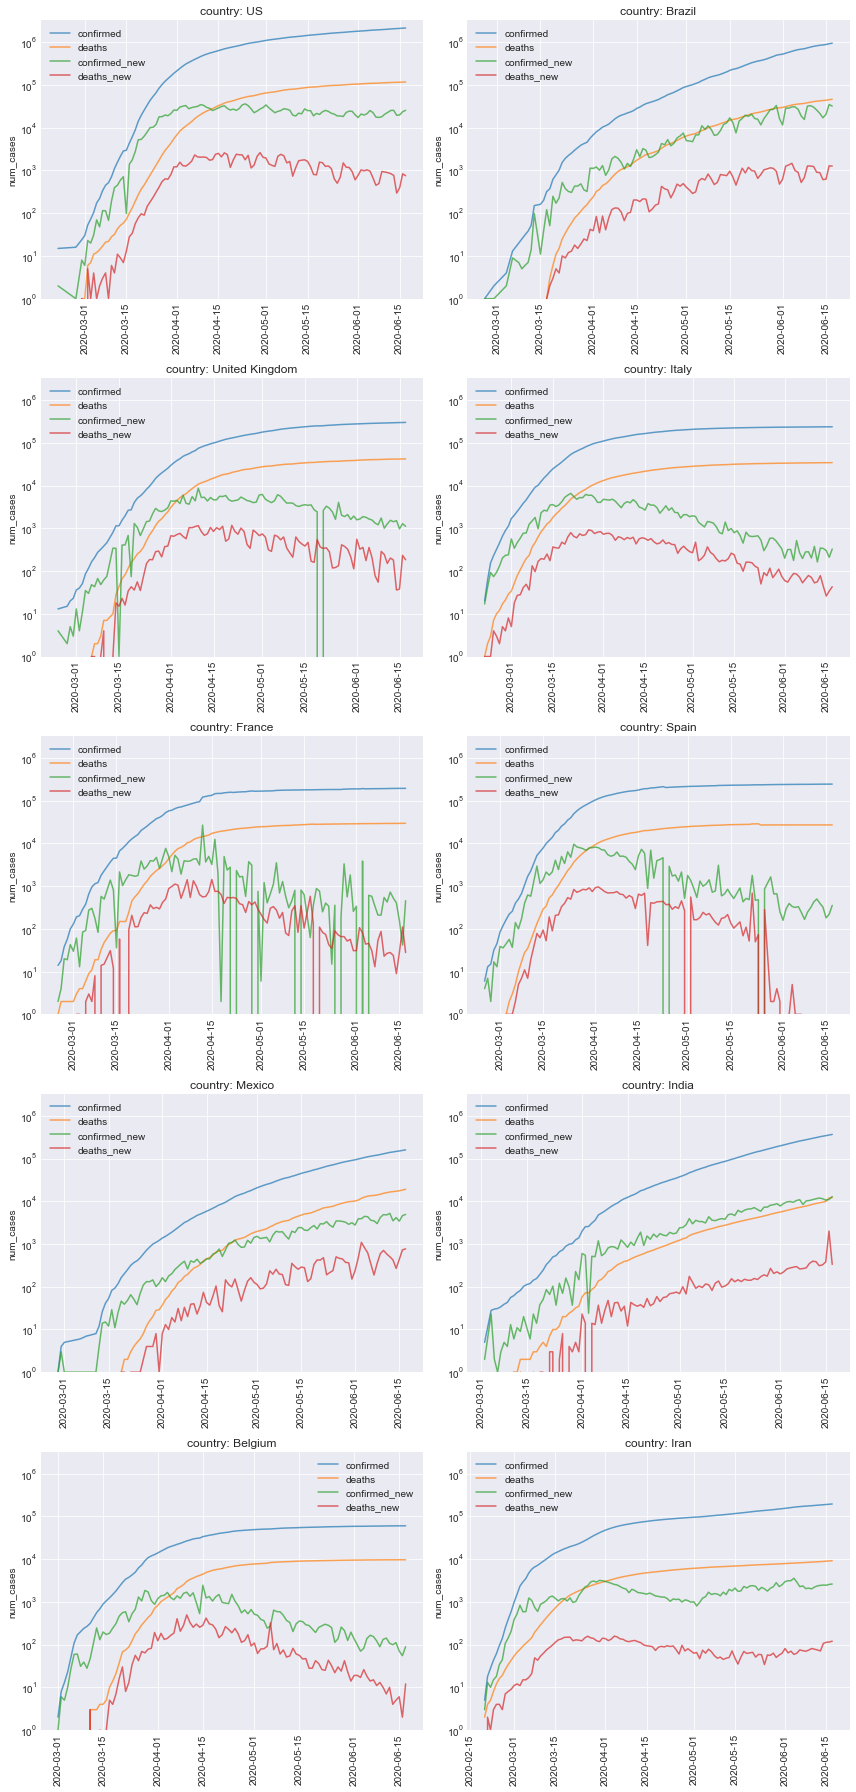

In [987]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

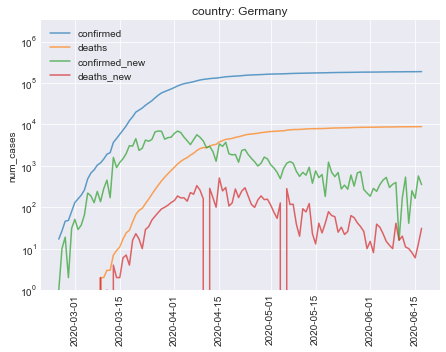

In [988]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [989]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-06-18 2020-06-24 2020-07-08  2020-06-18 2020-06-24   
country                                                                      
US                  2186138.0  2333256.0  2716193.0    118223.0   121993.0   
Brazil               975404.0  1153104.0  1703981.0     47149.0    53271.0   
United Kingdom       302253.0   310313.0   329963.0     42323.0    43127.0   
Italy                238115.0   239863.0   243991.0     34505.0    34782.0   
France               195264.0   197381.0   202412.0     29596.0    29828.0   
Spain                245036.0   246911.0   251342.0     27135.0    27135.0   
Mexico               164164.0   194601.0   289403.0     19390.0    22988.0   
India                380332.0   468019.0   759450.0     12757.0    18573.0   
Belgium               60347.0    60879.0    62136.0      9678.0     9713.0   
Iran                 197607.0   213929.0   257449.0      9269.0     9926.0   

                          mortality_rate_pred                        \
date           2020-07-08          2020-06-18 2020-06-24 2020-07-08   
country                                                               
US               131264.0            0.054078   0.052284   0.048326   
Brazil            70827.0            0.048338   0.046198   0.041566   
United Kingdom    45063.0            0.140025   0.138979   0.136570   
Italy             35435.0            0.144909   0.145008   0.145231   
France            30375.0            0.151569   0.151119   0.150065   
Spain             27135.0            0.110739   0.109898   0.107960   
Mexico            34196.0            0.118114   0.118129   0.118160   
India             44618.0            0.033542   0.039684   0.058750   
Belgium            9794.0            0.160373   0.159546   0.157622   
Iran              11646.0            0.046906   0.046399   0.045236   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.010914         5.245872e-03  
Brazil                        0.028286         2.055425e-02  
United Kingdom                0.004395         3.142178e-03  
Italy                         0.001220         1.330121e-03  
France                        0.001799         1.299133e-03  
Spain                         0.001271        -1.110223e-16  
Mexico                        0.028753         2.877287e-02  
India                         0.035182         6.460289e-02  
Belgium                       0.001462         5.994076e-04  
Iran                          0.013315         1.147774e-02

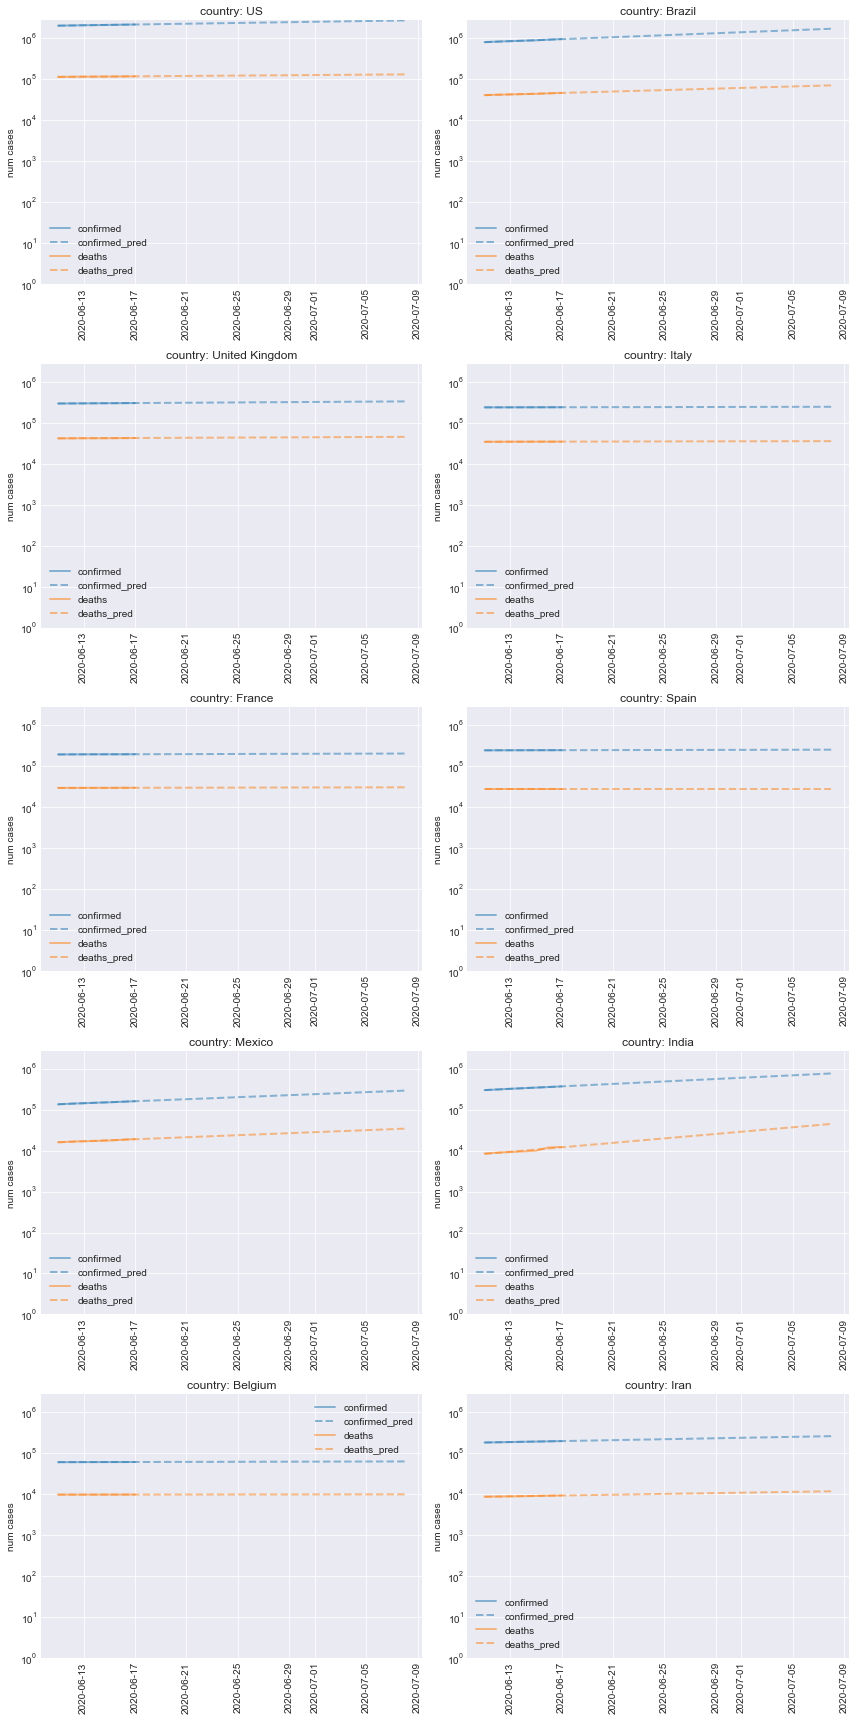

In [990]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [991]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-17_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [992]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


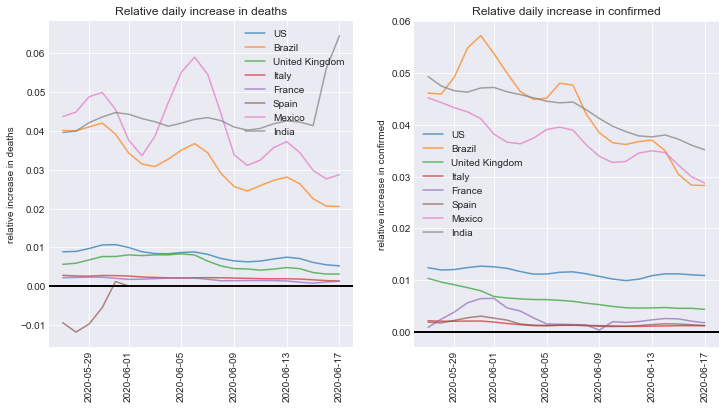

In [993]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-06-18 2020-06-24  2020-06-18 2020-06-24   
country                                                           
US                  2184205.0  2328713.0    118650.0   123211.0   
Brazil               994471.0  1212721.0     47742.0    55117.0   
United Kingdom       302570.0   311113.0     42459.0    43490.0   
Italy                238092.0   239802.0     34559.0    34921.0   
France               195463.0   197957.0     29597.0    29825.0   
Spain                245036.0   246968.0     27136.0    27137.0   
Mexico               166161.0   201101.0     19588.0    23657.0   
India                383822.0   478928.0     12052.0    16011.0   
Belgium               60454.0    61153.0      9692.0     9748.0   
Iran                 197388.0   213220.0      9210.0     9763.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-06-18 2020-06-24                           
country                                                                 
US                        0.054322   0.052909                0.010735   
Brazil                    0.048007   0.045449                0.033621   
United Kingdom            0.140328   0.139788                0.004652   
Italy                     0.145150   0.145624                0.001194   
France                    0.151420   0.150664                0.002115   
Spain                     0.110743   0.109881                0.001310   
Mexico                    0.117886   0.117637                0.032319   
India                     0.031400   0.033431                0.037584   
Belgium                   0.160320   0.159403                0.001919   
Iran                      0.046659   0.045788                0.012941   

               frac_increase_deaths  
date                                 
country                              
US                         0.006307  
Brazil                     0.024228  
United Kingdom             0.004008  
Italy                      0.001738  
France                     0.001278  
Spain                      0.000006  
Mexico                     0.031958  
India                      0.048477  
Belgium                    0.000955  
Iran                       0.009759

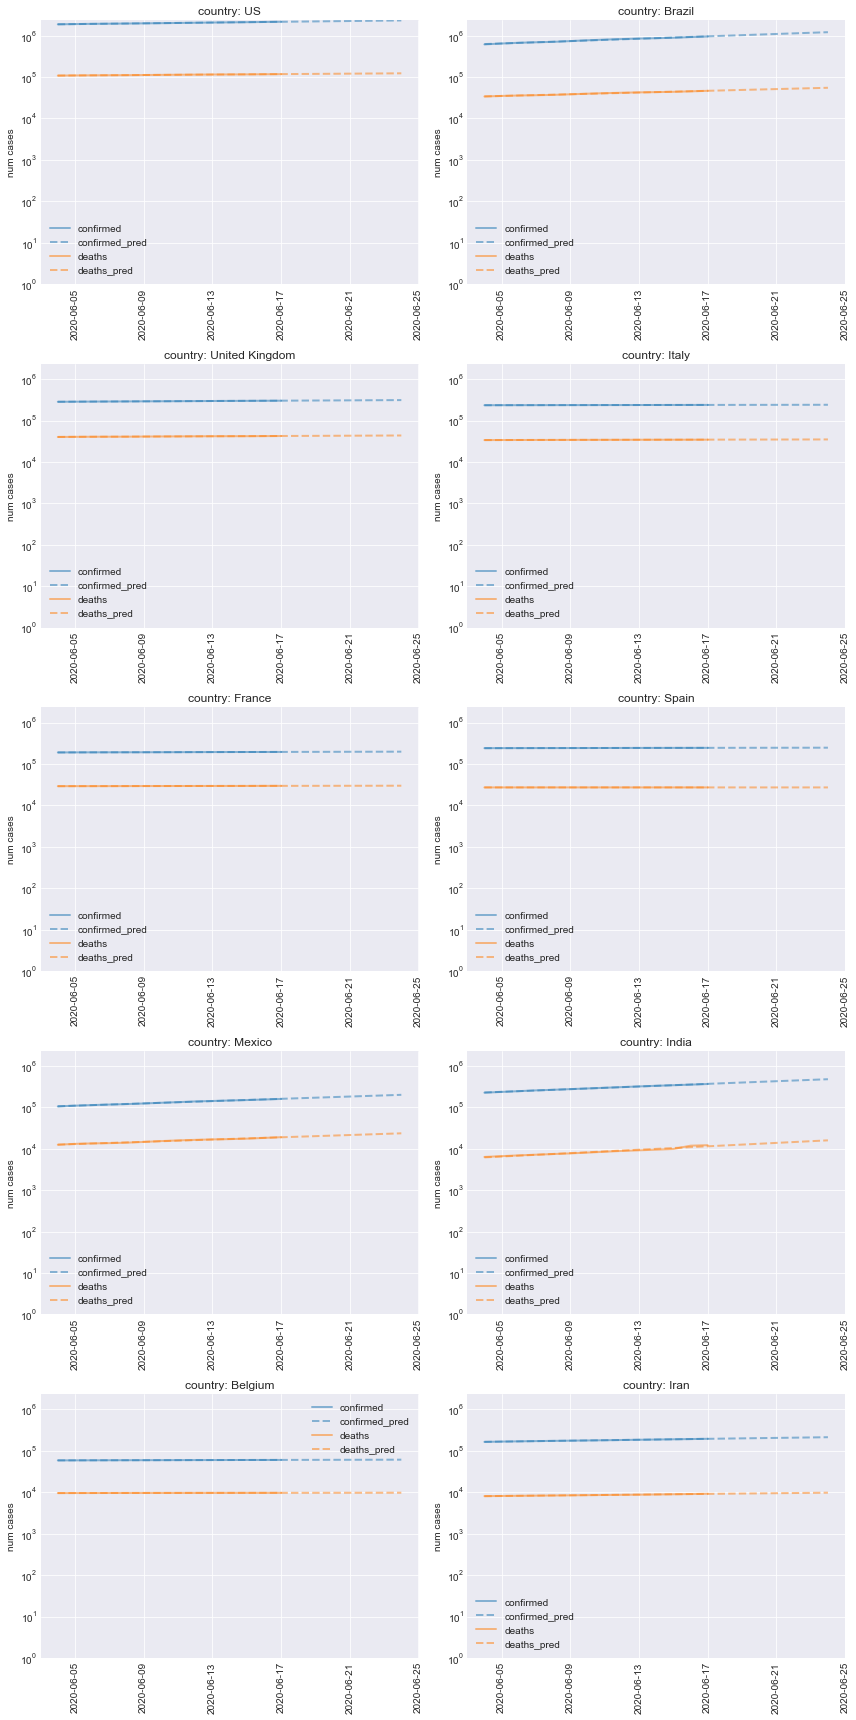

In [994]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [995]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-17_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [996]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

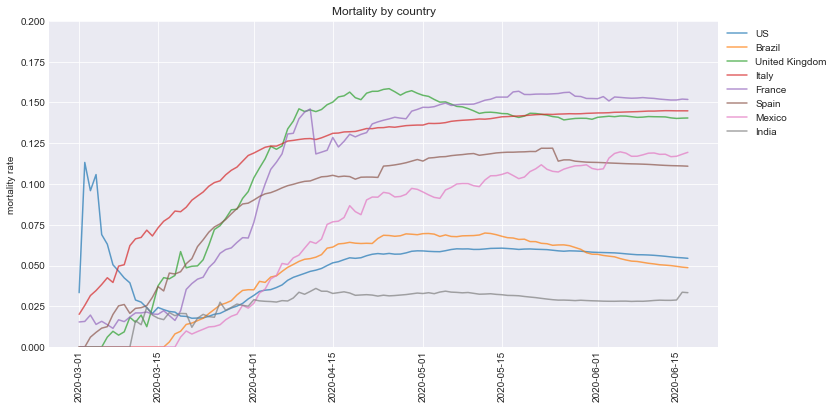

In [997]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [998]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

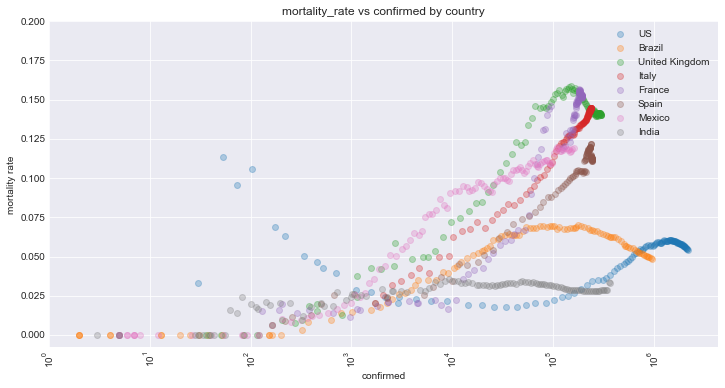

In [999]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [1000]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

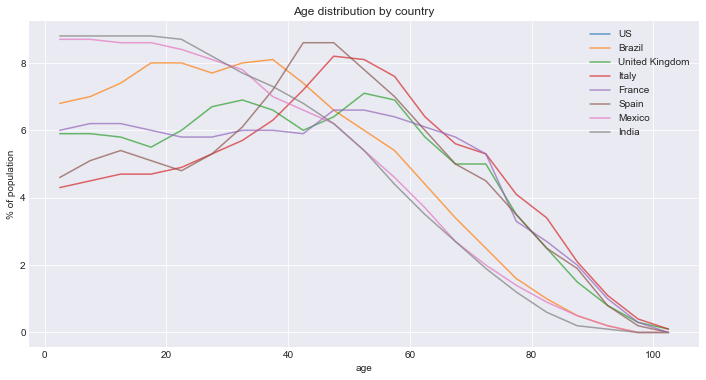

In [1001]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

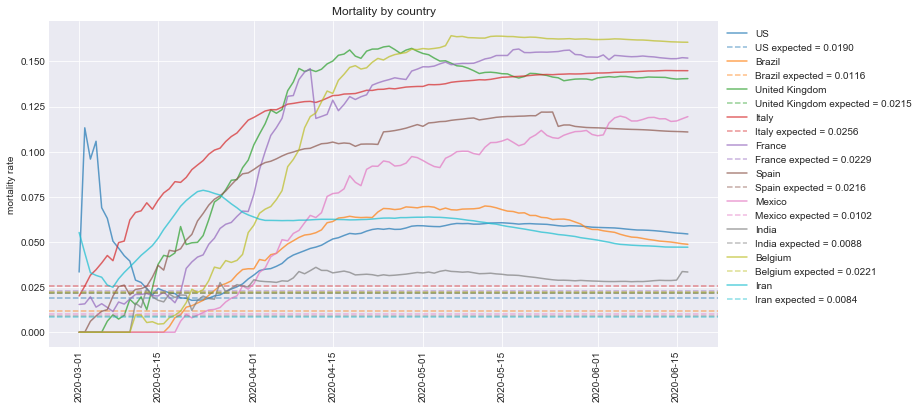

date         country  mortality_rate  confirmed    deaths
0 2020-06-17         Belgium        0.160597    60244.0    9675.0
1 2020-06-17          France        0.151834   194805.0   29578.0
2 2020-06-17           Italy        0.144844   237828.0   34448.0
3 2020-06-17  United Kingdom        0.140458   300717.0   42238.0
4 2020-06-17          Mexico        0.119404   159793.0   19080.0
5 2020-06-17           Spain        0.110903   244683.0   27136.0
6 2020-06-17              US        0.054416  2163290.0  117717.0
7 2020-06-17          Brazil        0.048682   955377.0   46510.0
8 2020-06-17            Iran        0.047090   195051.0    9185.0
9 2020-06-17           India        0.033348   366946.0   12237.0

In [1002]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

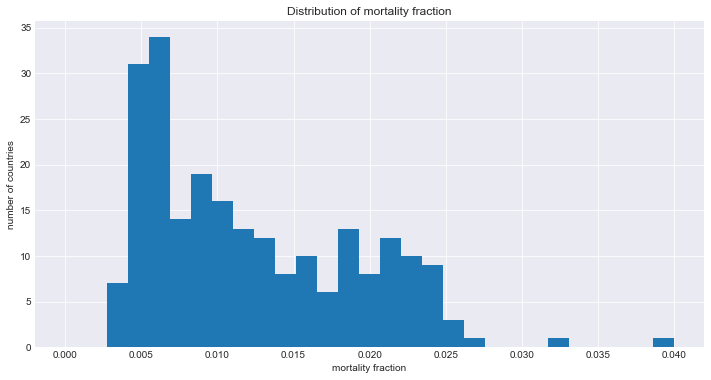

In [1003]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [1004]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [1005]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

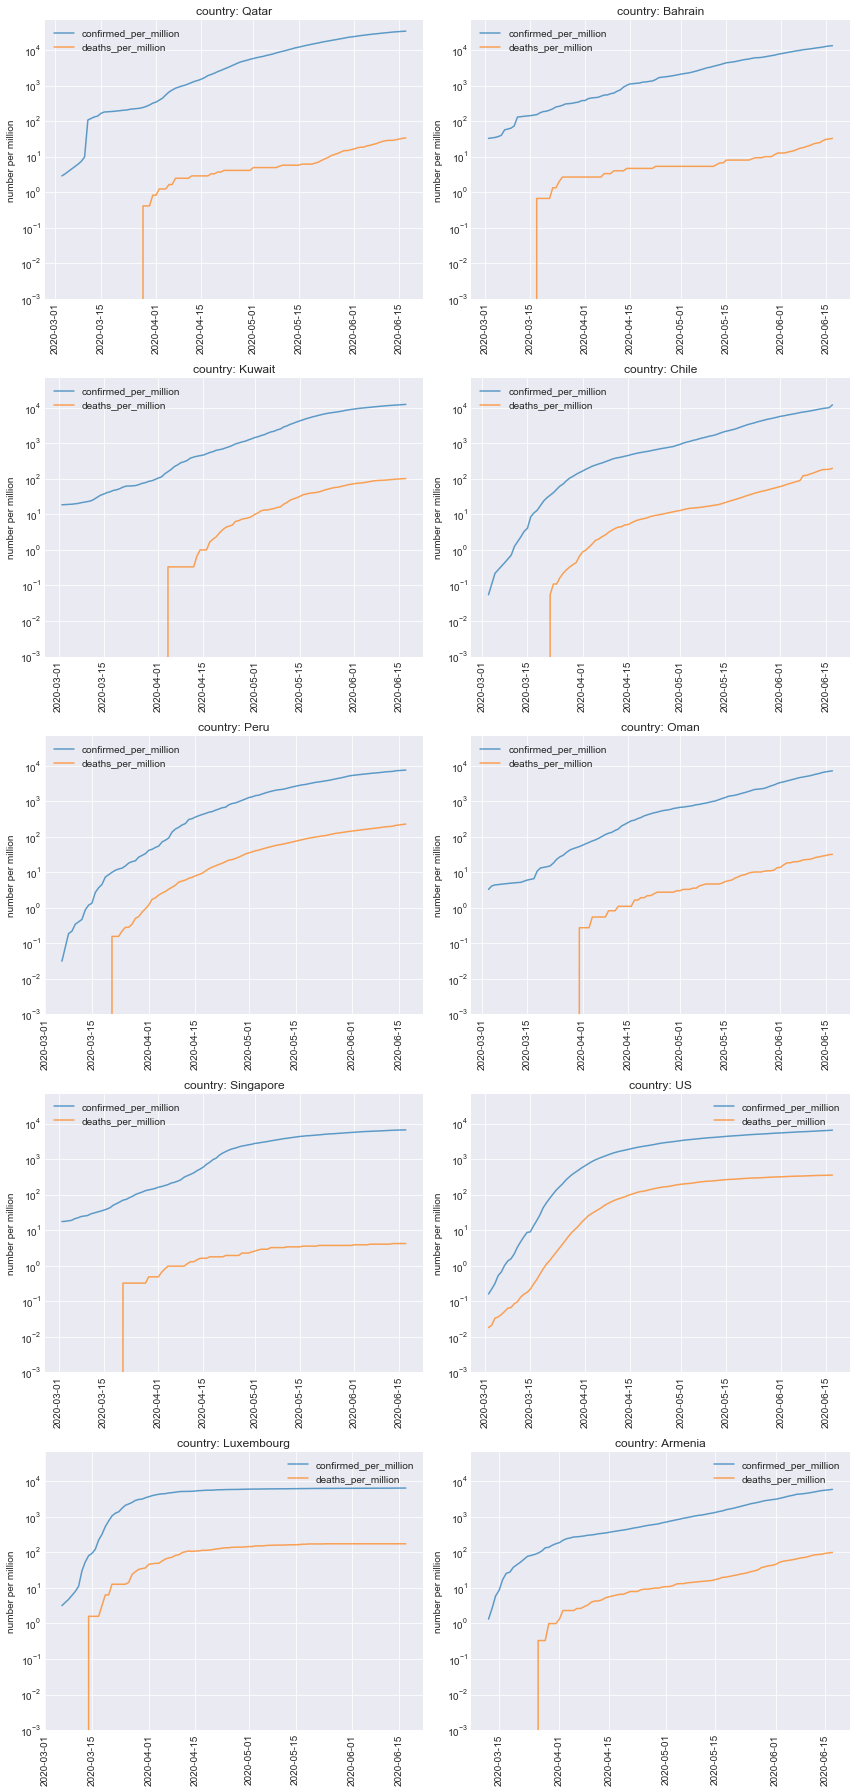

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    83174.0      82.0           34029.492172   
1     Bahrain    1505003.0    19961.0      49.0           13263.096486   
2      Kuwait    2993706.0    37533.0     306.0           12537.303262   
3       Chile   18186770.0   220628.0    3615.0           12131.236058   
4        Peru   31914989.0   240908.0    7257.0            7548.428107   
5        Oman    3634689.0    26079.0     116.0            7175.029280   
6   Singapore    6209660.0    41216.0      26.0            6637.400437   
7          US  332639102.0  2163290.0  117717.0            6503.414623   
8  Luxembourg     628381.0     4085.0     110.0            6500.833093   
9     Armenia    3021324.0    18033.0     302.0            5968.575366   

   deaths_per_million  mortality_rate  
0           33.549166        0.000986  
1           32.558075        0.002455  
2          102.214446        0.008153  
3          198.770865        0.016385  
4          227.385320        0.030124  
5           31.914698        0.004448  
6            4.187025        0.000631  
7          353.888040        0.054416  
8          175.053033        0.026928  
9           99.956178        0.016747

In [1006]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [1007]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
15         Belgium   11720716.0    60244.0    9675.0            5139.959026   
19  United Kingdom   65761117.0   300717.0   42238.0            4572.869405   
24           Italy   62402659.0   237828.0   34448.0            3811.183751   
18           Spain   50015792.0   244683.0   27136.0            4892.114874   
13          Sweden   10202491.0    54562.0    5041.0            5347.909643   
29          France   67848156.0   194805.0   29578.0            2871.190781   
7               US  332639102.0  2163290.0  117717.0            6503.414623   
31     Netherlands   17280397.0    49412.0    6093.0            2859.425047   
17         Ireland    5176569.0    25341.0    1710.0            4895.327388   
30         Ecuador   16904867.0    48490.0    4007.0            2868.404703   

    deaths_per_million  mortality_rate  
15          825.461516        0.160597  
19          642.294443        0.140458  
24          552.027759        0.144844  
18          542.548641        0.110903  
13          494.095021        0.092390  
29          435.944051        0.151834  
7           353.888040        0.054416  
31          352.596066        0.123310  
17          330.334629        0.067480  
30          237.032329        0.082636

### Mortality rate by deaths per capita, confirmed per capita

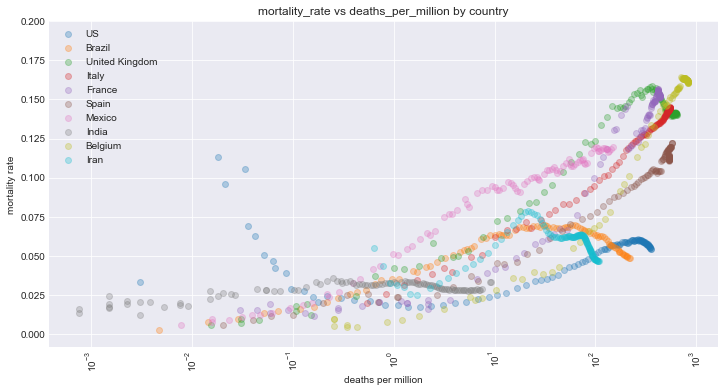

In [1008]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

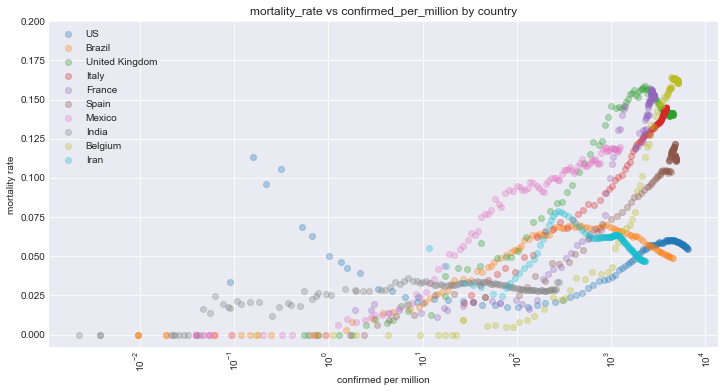

In [1009]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [1010]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

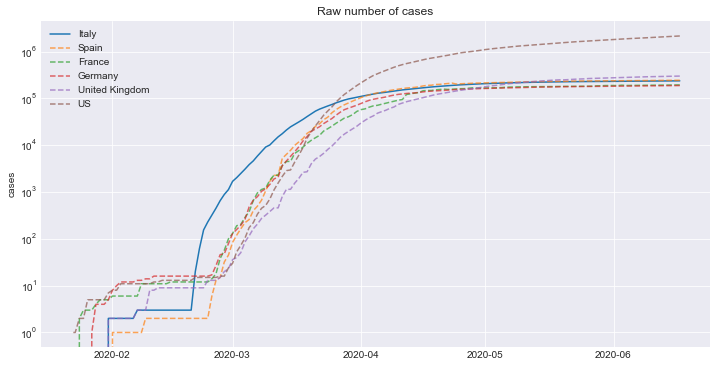

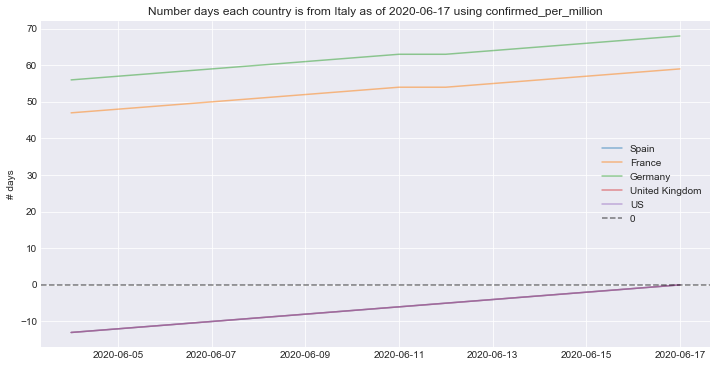

In [1011]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

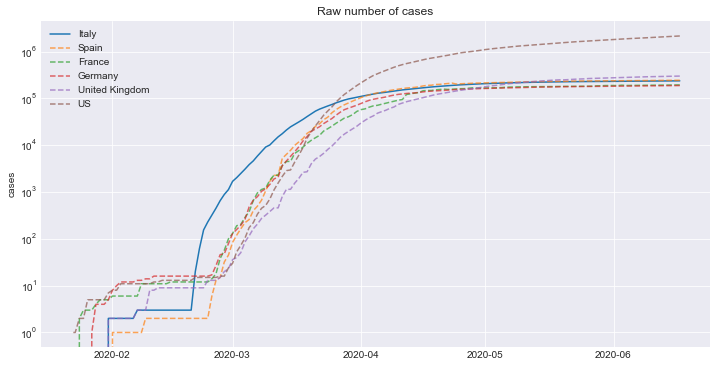

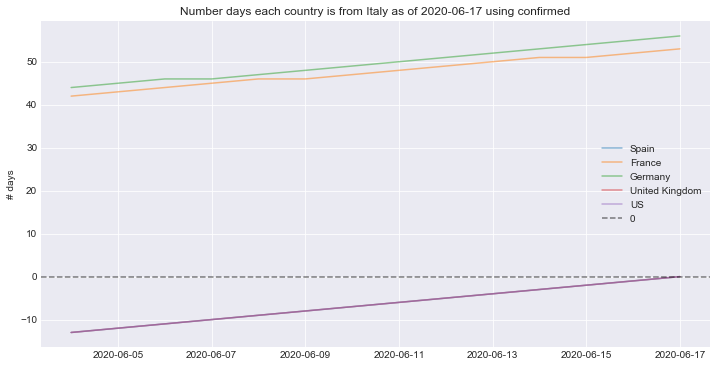

In [1012]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [1013]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [1014]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [1015]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [1016]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [1017]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-18       New York     385142            567   30939          30   
1  2020-06-18     New Jersey     167703            277   12835          43   
2  2020-06-18  Massachusetts     106151            266    7733          69   
3  2020-06-18       Illinois     134185            546    6485          87   
4  2020-06-18   Pennsylvania      84289            311    6319          43   
5  2020-06-18       Michigan      66497            228    6036           2   
6  2020-06-18     California     162798           3837    5271          71   
7  2020-06-18    Connecticut      45429             80    4219           9   
8  2020-06-18      Louisiana      48634            928    3062          20   
9  2020-06-18        Florida      82719           2610    3018          25   
10 2020-06-18       Maryland      62969            560    2996          14   
11 2020-06-18           Ohio      42422            412    2611          12   
12 2020-06-18        Georgia      60030            952    2575          46   
13 2020-06-18        Indiana      41013            227    2475          28   
14 2020-06-18          Texas      97699           4130    2089          40   

    mortality_rate  
0         0.080331  
1         0.076534  
2         0.072849  
3         0.048329  
4         0.074968  
5         0.090771  
6         0.032378  
7         0.092870  
8         0.062960  
9         0.036485  
10        0.047579  
11        0.061548  
12        0.042895  
13        0.060347  
14        0.021382

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [1018]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

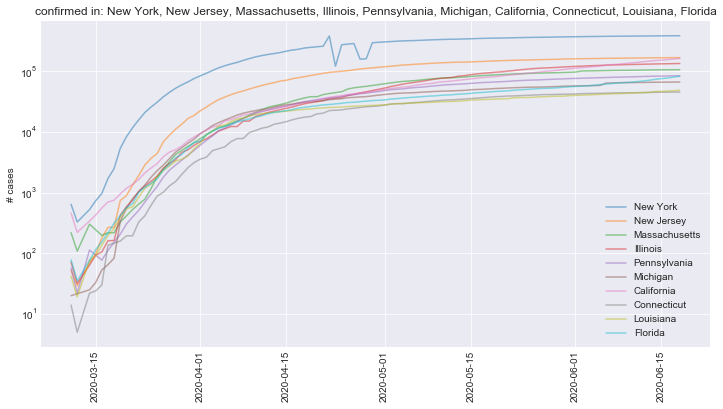

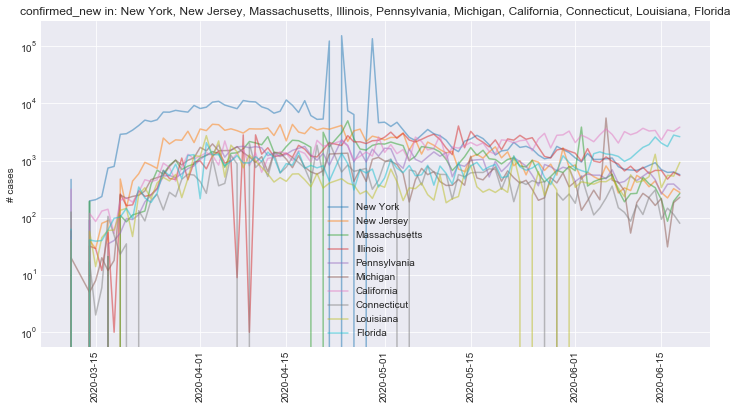

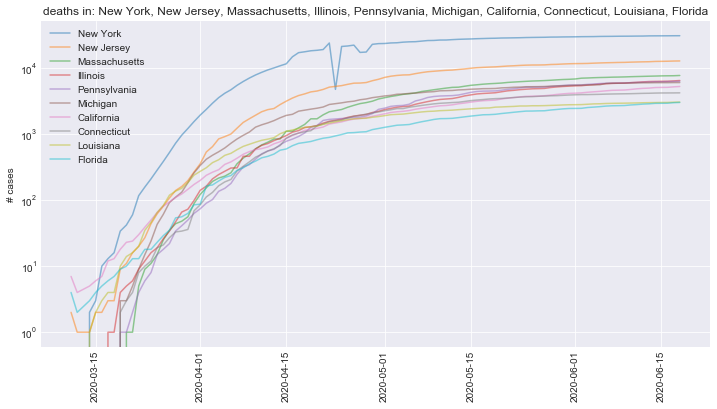

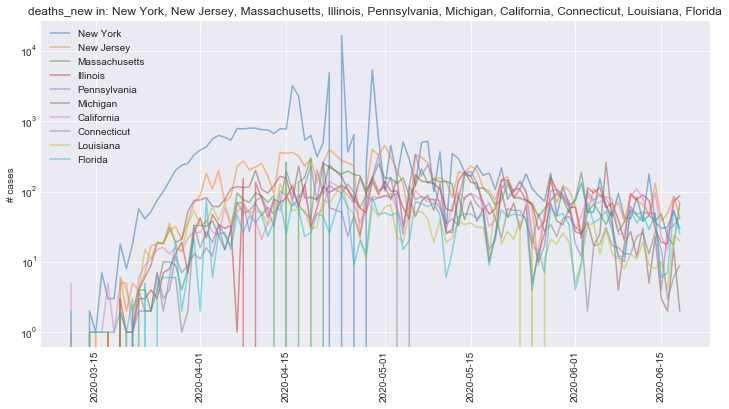

In [1019]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

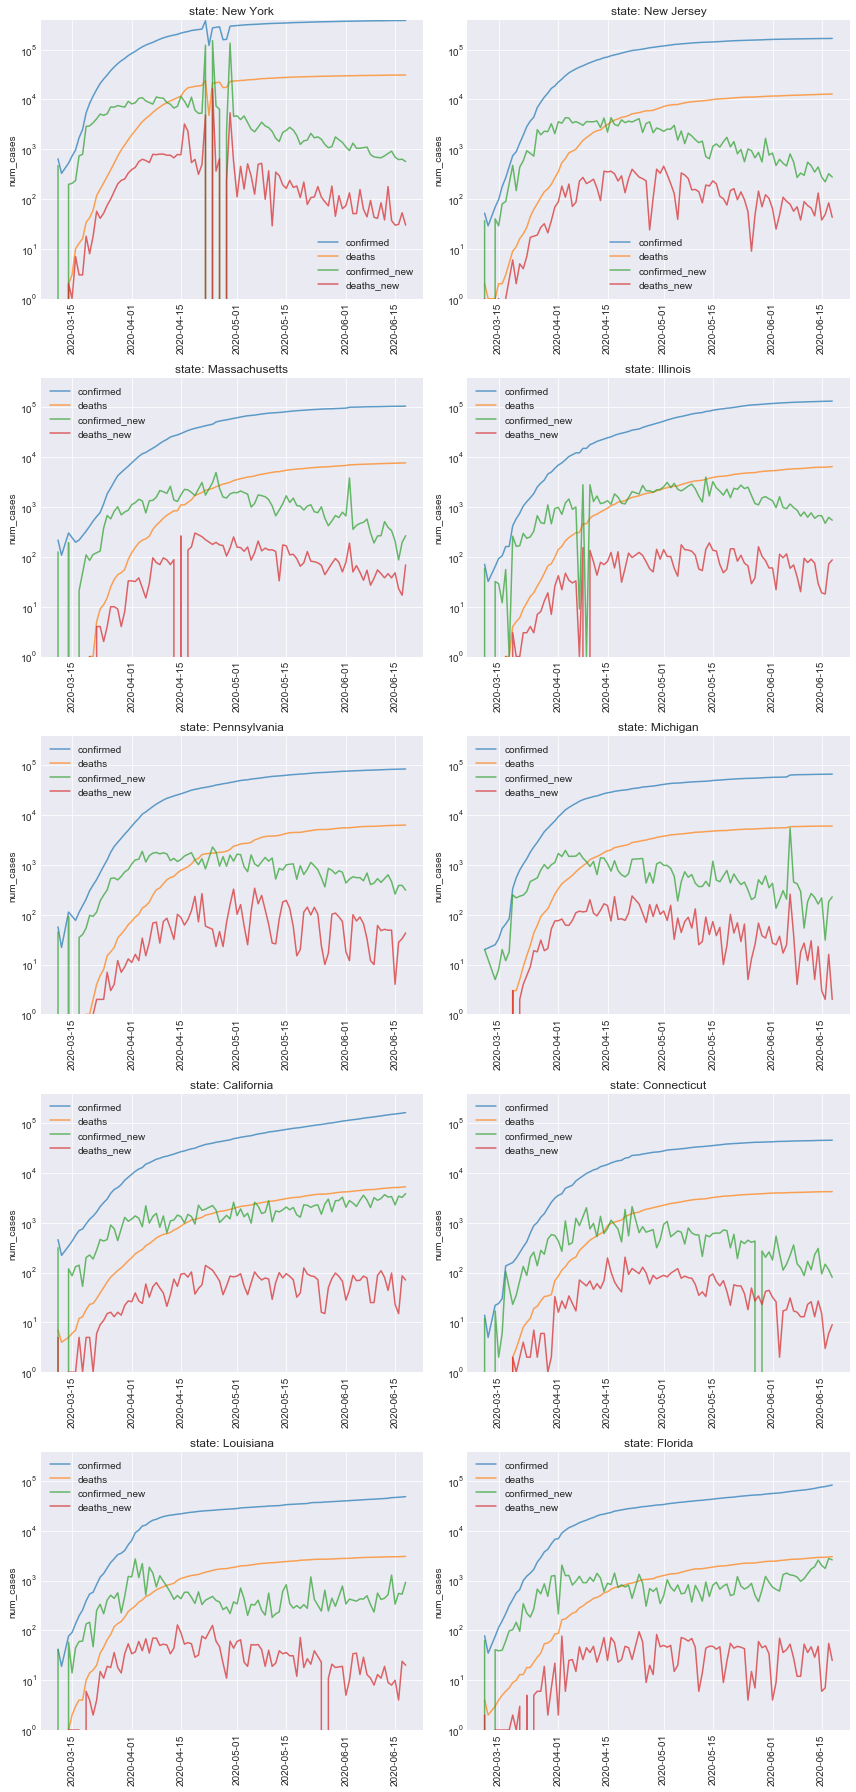

In [1020]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

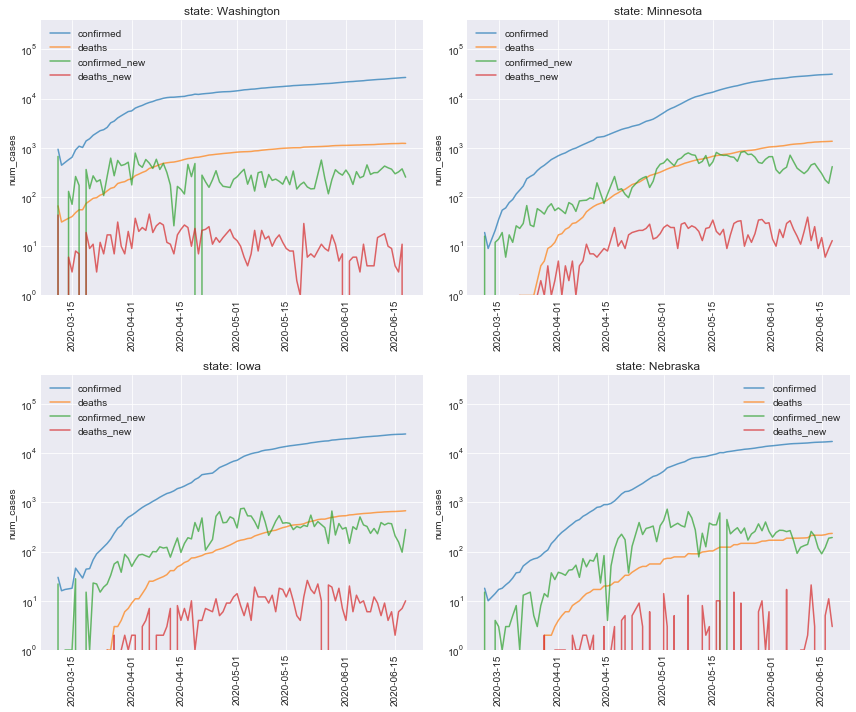

In [1021]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-06-19 2020-06-25 2020-07-09  2020-06-19 2020-06-25   
state                                                                       
New York            386009.0   390305.0   400516.0     31015.0    31327.0   
New Jersey          168058.0   169943.0   174425.0     12918.0    13334.0   
Massachusetts       106410.0   107803.0   111125.0      7761.0     7993.0   
Illinois            134849.0   138560.0   147621.0      6496.0     6768.0   
Pennsylvania         84768.0    87198.0    93142.0      6346.0     6541.0   
Michigan             66638.0    67638.0    70031.0      6048.0     6101.0   
California          165883.0   187817.0   250946.0      5312.0     5656.0   
Connecticut          45677.0    46659.0    49033.0      4237.0     4312.0   
Louisiana            49302.0    53765.0    65815.0      3065.0     3137.0   
Florida              85024.0   101646.0   154185.0      3042.0     3214.0   

                         mortality_rate_pred                        \
date          2020-07-09          2020-06-19 2020-06-25 2020-07-09   
state                                                                
New York         32069.0            0.080348   0.080263   0.080069   
New Jersey       14358.0            0.076866   0.078462   0.082316   
Massachusetts     8561.0            0.072935   0.074145   0.077039   
Illinois          7448.0            0.048172   0.048845   0.050454   
Pennsylvania      7019.0            0.074863   0.075013   0.075358   
Michigan          6227.0            0.090759   0.090201   0.088918   
California        6548.0            0.032023   0.030114   0.026093   
Connecticut       4490.0            0.092760   0.092415   0.091571   
Louisiana         3314.0            0.062168   0.058347   0.050353   
Florida           3656.0            0.035778   0.031620   0.023712   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.001846             0.001672  
New Jersey                   0.001861             0.005295  
Massachusetts                0.002170             0.004922  
Illinois                     0.004535             0.006865  
Pennsylvania                 0.004721             0.005057  
Michigan                     0.002486             0.001463  
California                   0.020913             0.010517  
Connecticut                  0.003552             0.002898  
Louisiana                    0.014549             0.003919  
Florida                      0.030208             0.009236

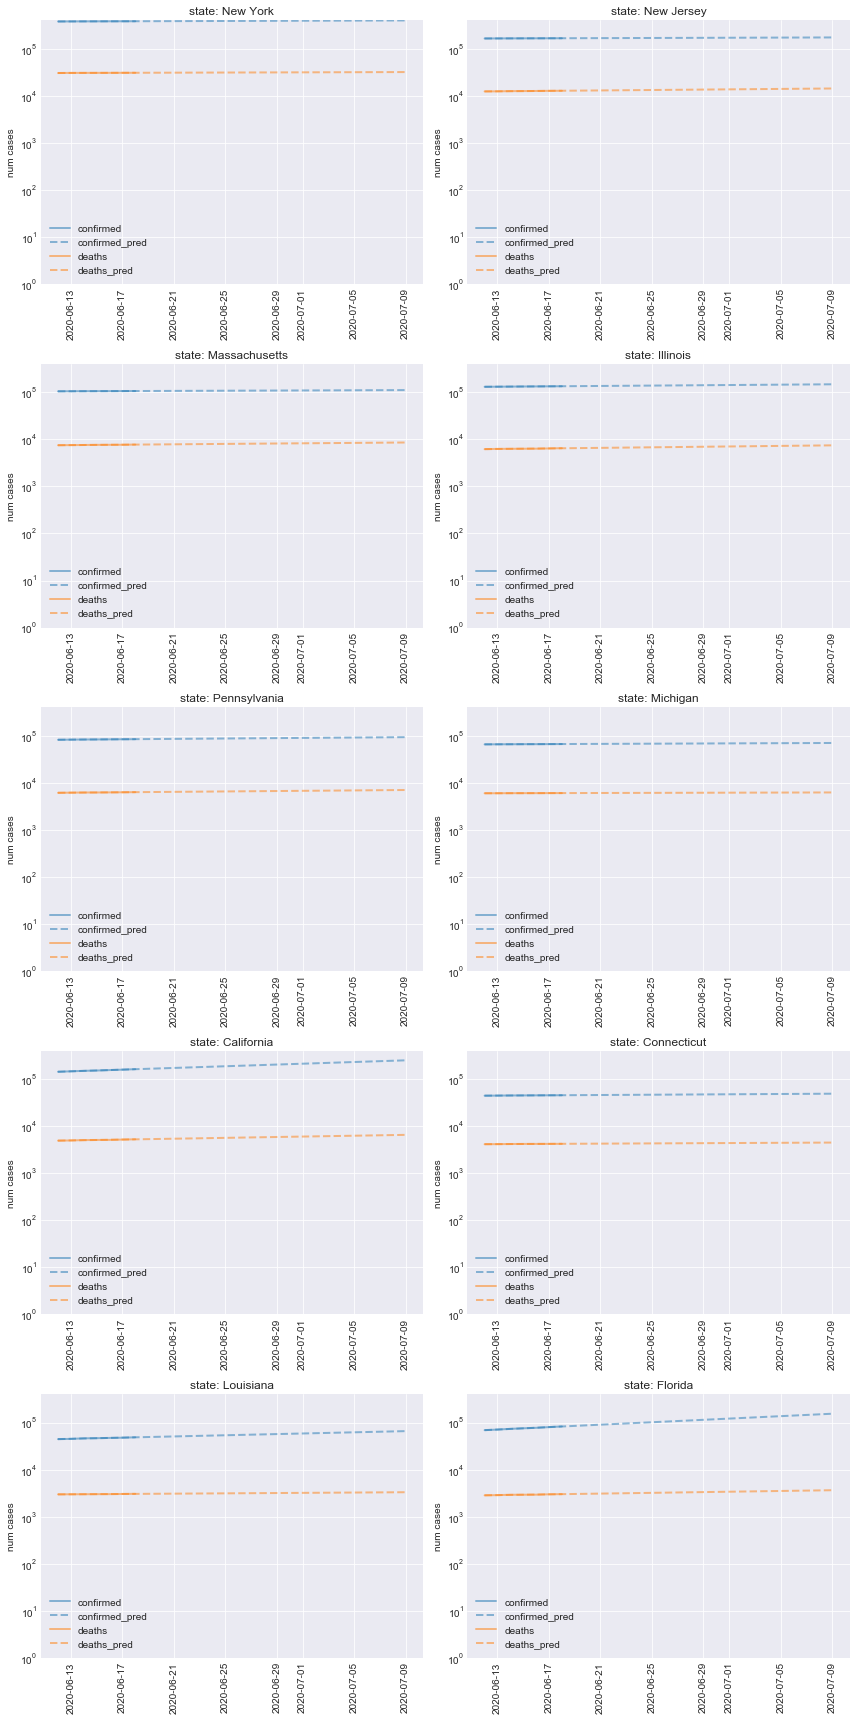

In [1022]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-06-19 2020-06-25 2020-07-09  2020-06-19 2020-06-25   
state                                                                       
New York            386248.0   390895.0   401957.0     31054.0    31438.0   
New Jersey          168356.0   170726.0   176387.0     12926.0    13357.0   
Massachusetts       106721.0   108638.0   113248.0      7776.0     8036.0   
Illinois            135352.0   139830.0   150862.0      6553.0     6932.0   
Pennsylvania         85090.0    88068.0    95430.0      6368.0     6607.0   
Michigan             67716.0    70129.0    76099.0      6112.0     6255.0   
California          166506.0   189774.0   257506.0      5360.0     5797.0   
Connecticut          45719.0    46763.0    49291.0      4255.0     4360.0   
Louisiana            48814.0    52451.0    62027.0      3067.0     3144.0   
Florida              83114.0    96040.0   134564.0      3062.0     3274.0   

                         mortality_rate_pred                        \
date          2020-07-09          2020-06-19 2020-06-25 2020-07-09   
state                                                                
New York         32354.0            0.080399   0.080426   0.080491   
New Jersey       14420.0            0.076778   0.078236   0.081752   
Massachusetts     8675.0            0.072863   0.073970   0.076602   
Illinois          7903.0            0.048415   0.049574   0.052386   
Pennsylvania      7200.0            0.074838   0.075022   0.075448   
Michigan          6602.0            0.090259   0.089193   0.086755   
California        6960.0            0.032191   0.030547   0.027028   
Connecticut       4615.0            0.093069   0.093236   0.093628   
Louisiana         3331.0            0.062830   0.059942   0.053702   
Florida           3830.0            0.036841   0.034090   0.028462   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.001995             0.002052  
New Jersey                   0.002333             0.005484  
Massachusetts                0.002973             0.005481  
Illinois                     0.005439             0.009411  
Pennsylvania                 0.005751             0.006160  
Michigan                     0.005853             0.003866  
California                   0.022040             0.013143  
Connecticut                  0.003768             0.004071  
Louisiana                    0.012050             0.004130  
Florida                      0.024384             0.011248

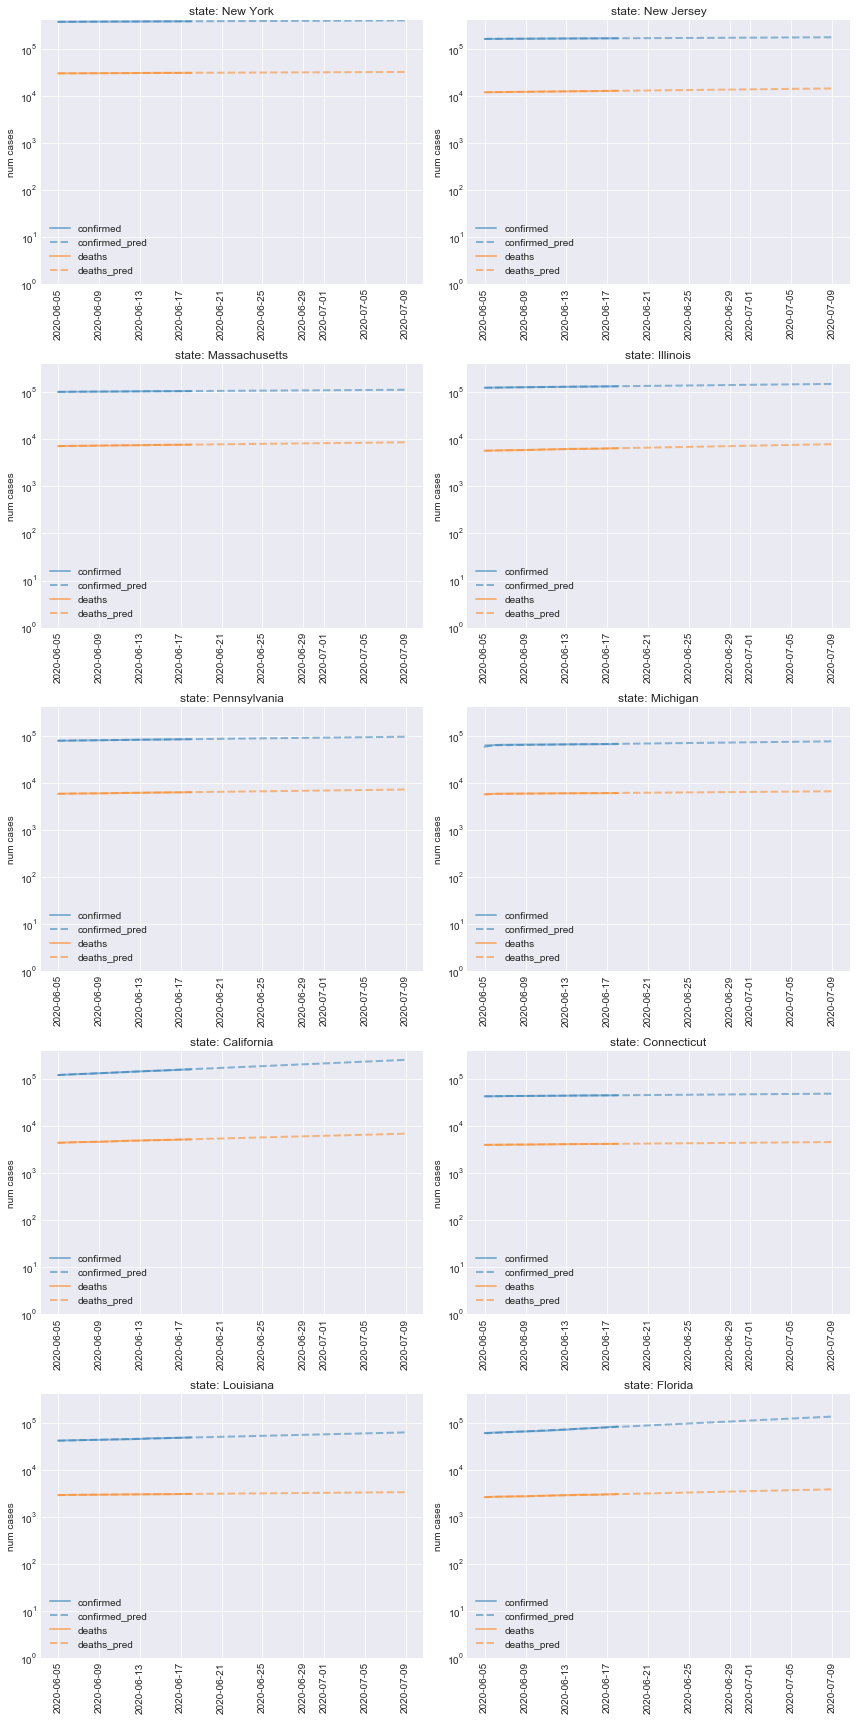

In [1023]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [1024]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [1025]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-06-18              Arkansas      13606     197           9   
1  2020-06-18                  Utah      15344     149           4   
2  2020-06-18             Tennessee      32114     498           5   
3  2020-06-18               Montana        630      20           1   
4  2020-06-18              Nebraska      17231     234           3   
5  2020-06-18               Arizona      40937    1249          21   
6  2020-06-18               Georgia      60030    2575          46   
7  2020-06-18            New Mexico      10065     452           5   
8  2020-06-18                Oregon       6218     183           1   
9  2020-06-18                 Texas      97699    2089          40   
10 2020-06-18           Mississippi      20641     938          23   
11 2020-06-18            California     162798    5271          71   
12 2020-06-18         New Hampshire       5436     330           4   
13 2020-06-18          Rhode Island      16213     876          11   
14 2020-06-18          South Dakota       6050      78           1   
15 2020-06-18        North Carolina      46934    1181          12   
16 2020-06-18                Alaska        695      12           0   
17 2020-06-18             Minnesota      31296    1357          13   
18 2020-06-18               Florida      82719    3018          25   
19 2020-06-18                  Iowa      24460     675          10   
20 2020-06-18                  Ohio      42422    2611          12   
21 2020-06-18  District of Columbia       9847     523           3   
22 2020-06-18              Missouri      17069     909          18   
23 2020-06-18              Illinois     134185    6485          87   
24 2020-06-18              Maryland      62969    2996          14   
25 2020-06-18              Kentucky      12995     518          13   
26 2020-06-18        South Carolina      20556     617          10   
27 2020-06-18             Wisconsin      23456     713          10   
28 2020-06-18               Alabama      27312     790           5   
29 2020-06-18              Virginia      55775    1583          13   
30 2020-06-18               Indiana      41013    2475          28   
31 2020-06-18              Delaware      10444     426           2   
32 2020-06-18            New Jersey     167703   12835          43   
33 2020-06-18                 Idaho       3632      88           0   
34 2020-06-18          Pennsylvania      84289    6319          43   
35 2020-06-18              Colorado      29656    1631          14   
36 2020-06-18         Massachusetts     106151    7733          69   
37 2020-06-18            Washington      26784    1226          -5   
38 2020-06-18                Nevada      11854     473           6   
39 2020-06-18             Louisiana      48634    3062          20   
40 2020-06-18           Connecticut      45429    4219           9   
41 2020-06-18           Puerto Rico       6003     147           0   
42 2020-06-18                 Maine       2836     102           1   
43 2020-06-18                Kansas      11644     247           1   
44 2020-06-18              Oklahoma       8904     364           1   
45 2020-06-18         West Virginia       2376      88           0   
46 2020-06-18              New York     385142   30939          30   
47 2020-06-18              Michigan      66497    6036           2   
48 2020-06-18          North Dakota       3166      74           0   
49 2020-06-18                  Guam        188       5           0   
50 2020-06-18                Hawaii        744      17           0   
51 2020-06-18        Virgin Islands         73       6           0   
52 2020-06-18               Vermont       1130      55           0   
53 2020-06-18               Wyoming       1114      18           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.037                 0.021  
1                     0.024                 0.018  
2 

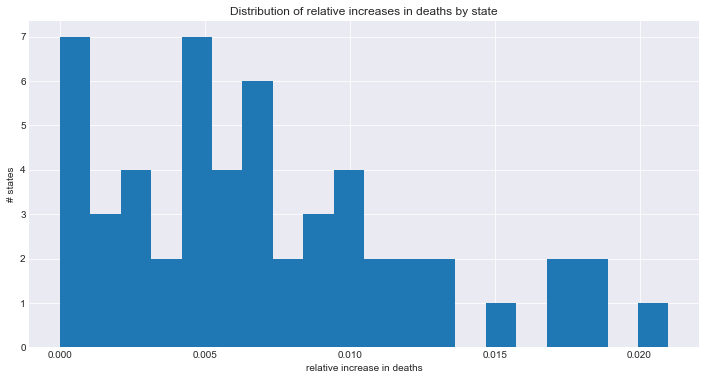

In [1026]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

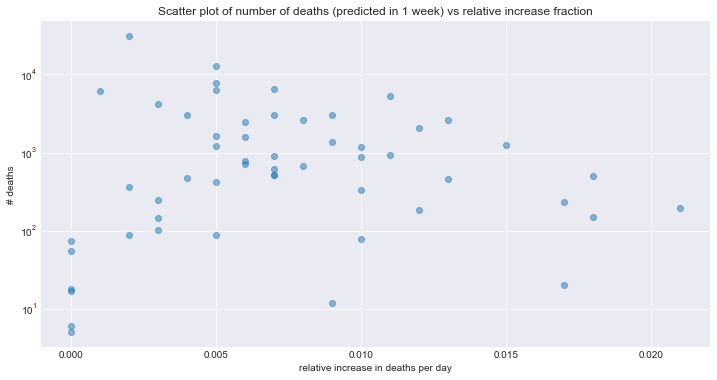

In [1027]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [1028]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

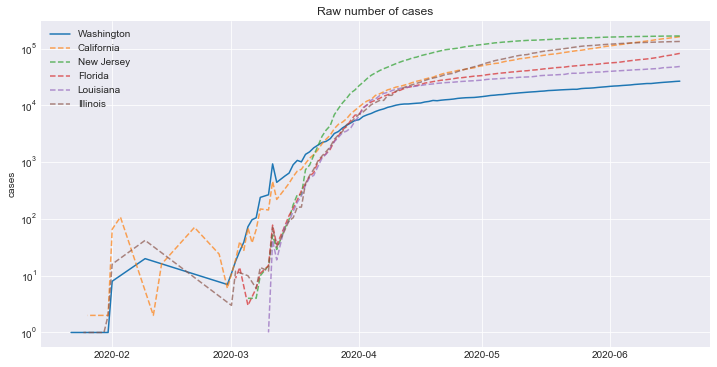

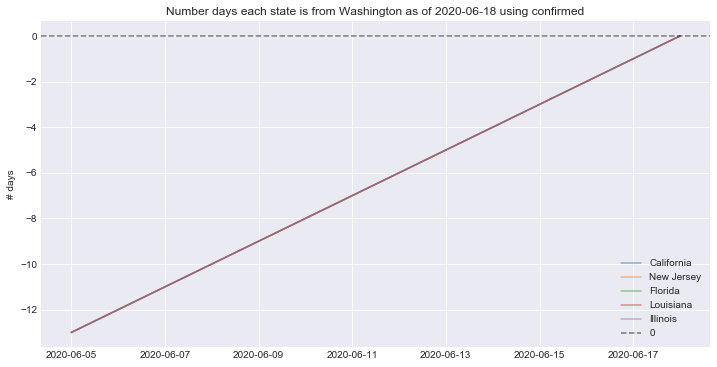

In [1029]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

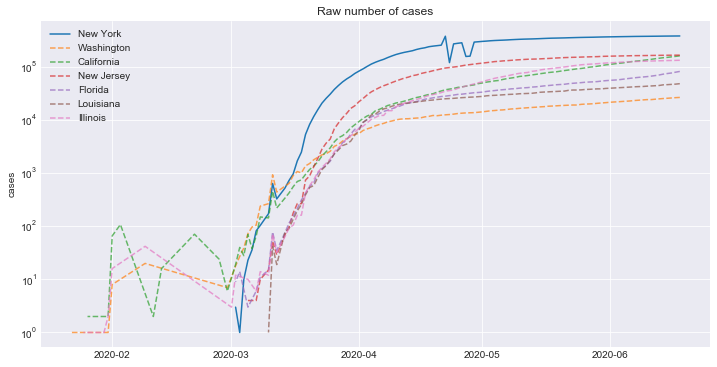

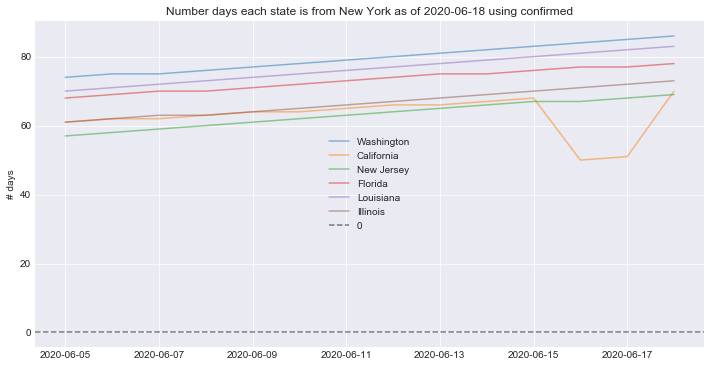

In [1030]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

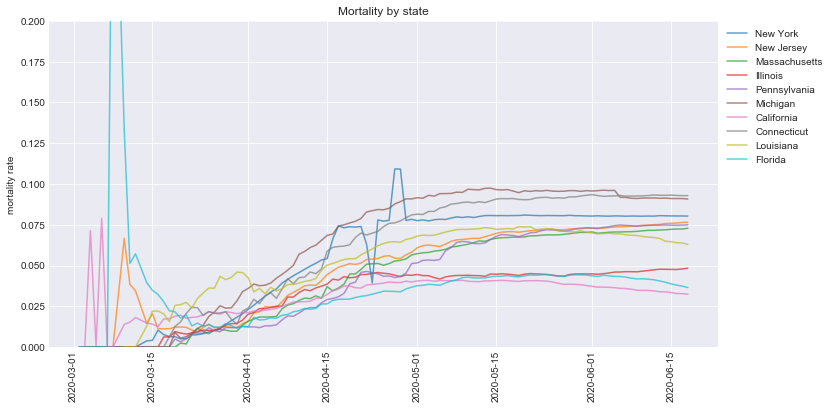

In [1031]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

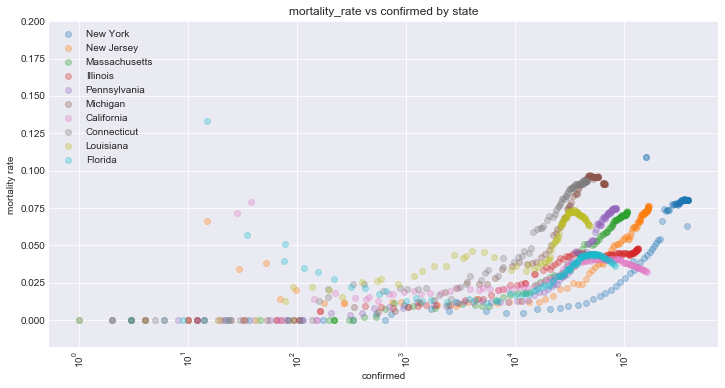

In [1032]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

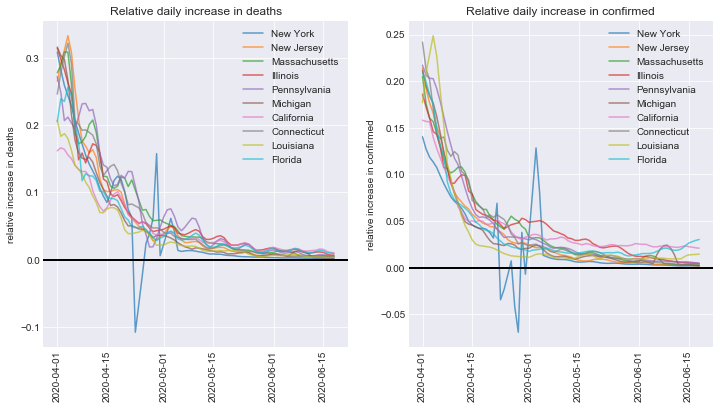

In [1033]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [1034]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [1035]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-06-19 2020-06-25 2020-07-02 2020-07-16   
state                                                                      
California                         3301       3638       4075       5113   
Florida                            2073       2915       4341       9624   
New York                            649        508        381        215   
Louisiana                           591        708        872       1326   
Illinois                            562        403        273        125   
Pennsylvania                        424        367        311        222   
Michigan                            322        273        225        153   
New Jersey                          312        225        153         71   
Massachusetts                       268        181        114         46   
Connecticut                         143        114         88         52   

                                                                      \
date          2020-08-13 2020-09-10 2020-10-08 2020-11-05 2020-12-03   
state                                                                  
California          8049      12671      19947      31400      49430   
Florida            47298     232440    1142297    5613665   27587607   
New York              68         21          6          2          0   
Louisiana           3062       7072      16330      37707      87067   
Illinois              26          5          1          0          0   
Pennsylvania         114         58         29         15          7   
Michigan              70         32         15          7          3   
New Jersey            15          3          0          0          0   
Massachusetts          7          1          0          0          0   
Connecticut           18          6          2          0          0   

                         deaths_new_smooth_pred                        \
date          2021-01-28             2020-06-19 2020-06-25 2020-07-02   
state                                                                   
California        122487                     66         68         70   
Florida        666268101                     33         33         33   
New York               0                     57         47         38   
Louisiana         464214                     12         11          9   
Illinois               0                     56         49         43   
Pennsylvania           2                     35         28         22   
Michigan               0                     19         14         10   
New Jersey             0                     65         61         57   
Massachusetts          0                     35         27         20   
Connecticut            0                     13         10          7   

                                                                      \
date          2020-07-16 2020-08-13 2020-09-10 2020-10-08 2020-11-05   
state                                                                  
California            73         81         90        100        112   
Florida               33         34         35         35         36   
New York              25         10          4          2          0   
Louisiana              7          4          2          1          0   
Illinois              32         18         10          5          3   
Pennsylvania          13          5          1          0          0   
Michigan               5          1          0          0          0   
New Jersey            49         37         28         21         16   
Massachusetts         11          3          1          0          0   
Connecticut            4          1          0          0          0   

                                    frac_increase_confirmed  \
date          2020-12-03 2021-01-28                           
state                                                         
California  

In [1036]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

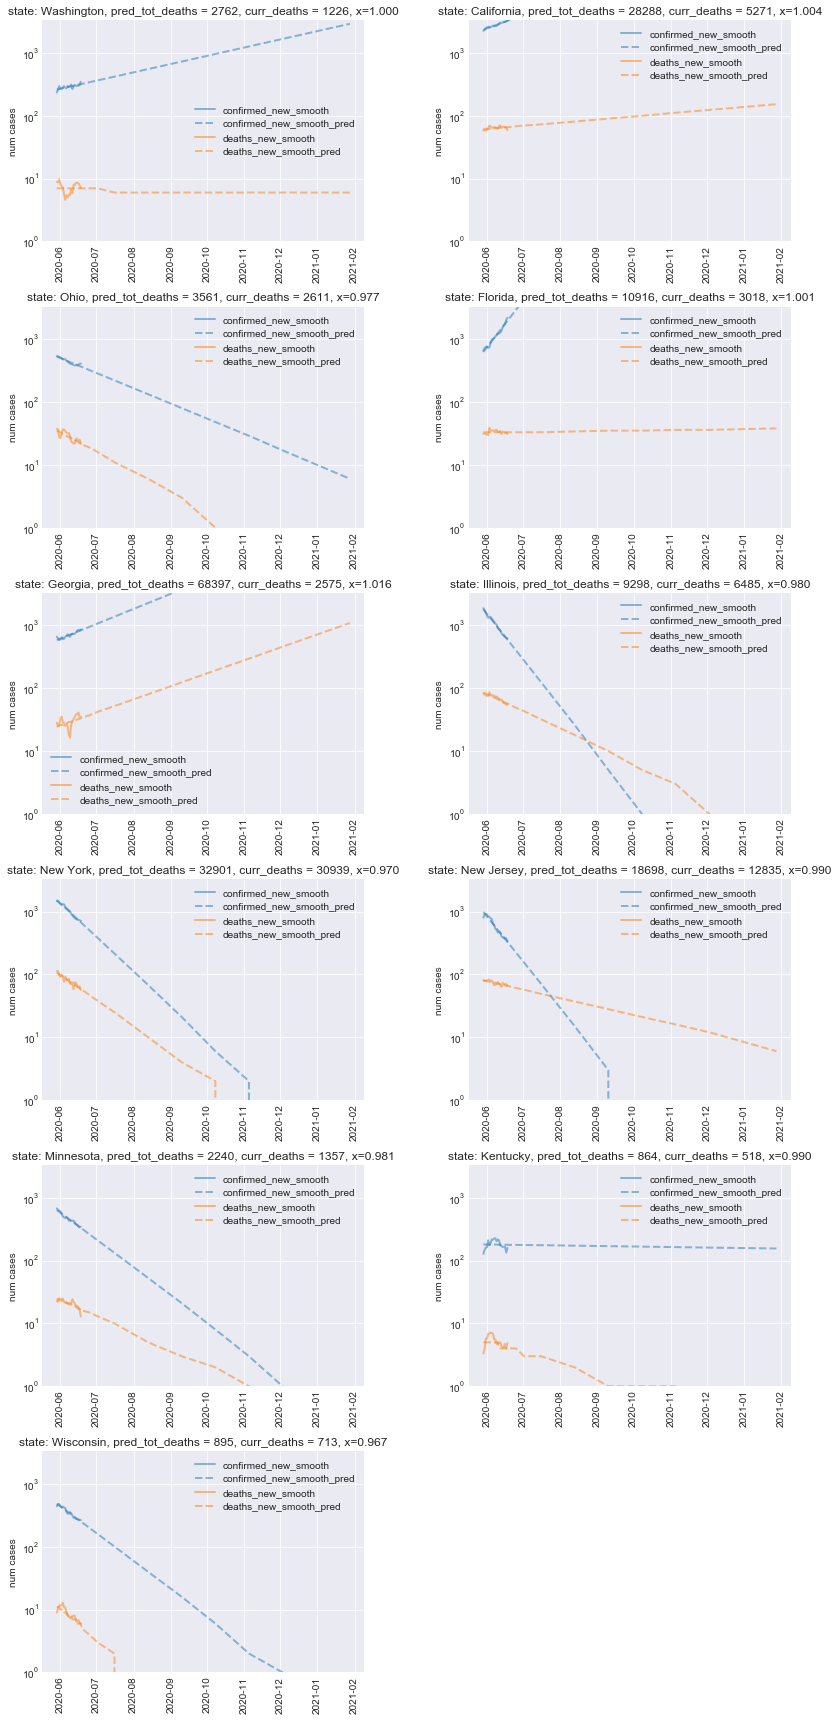

In [1037]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
)

In [1038]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-06-18_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [1039]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

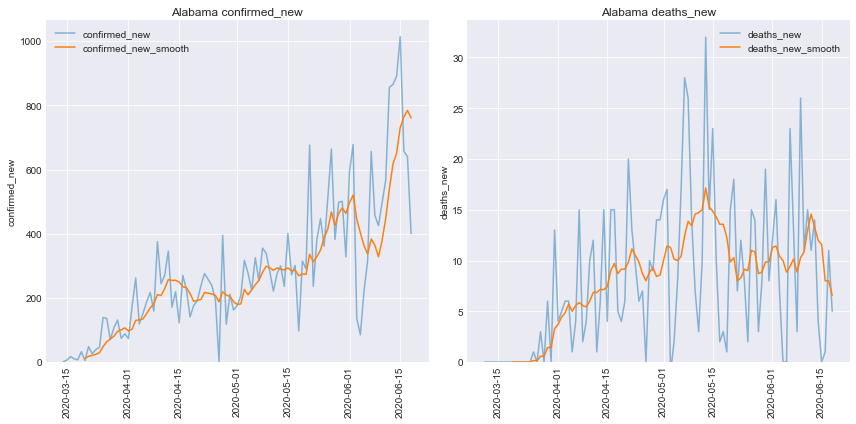

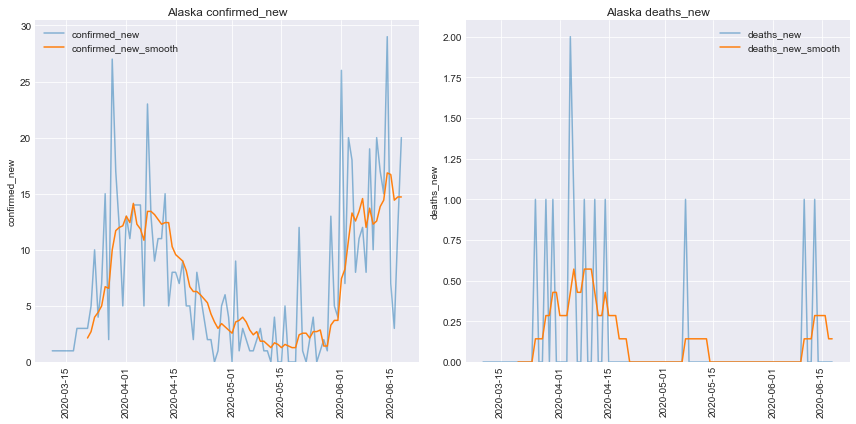

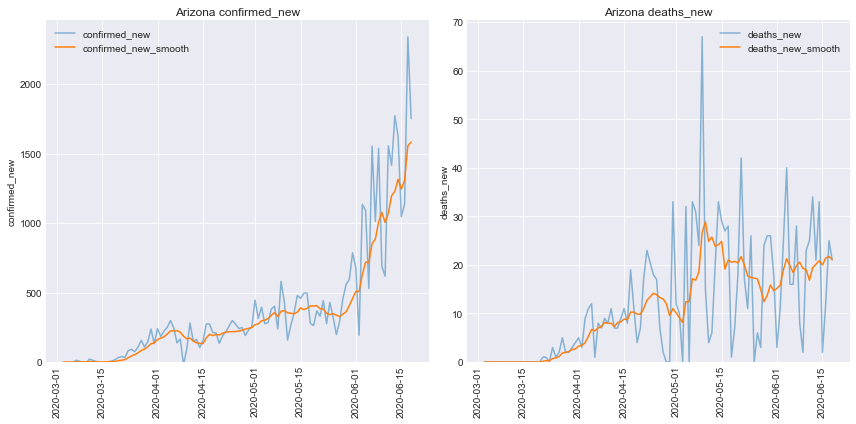

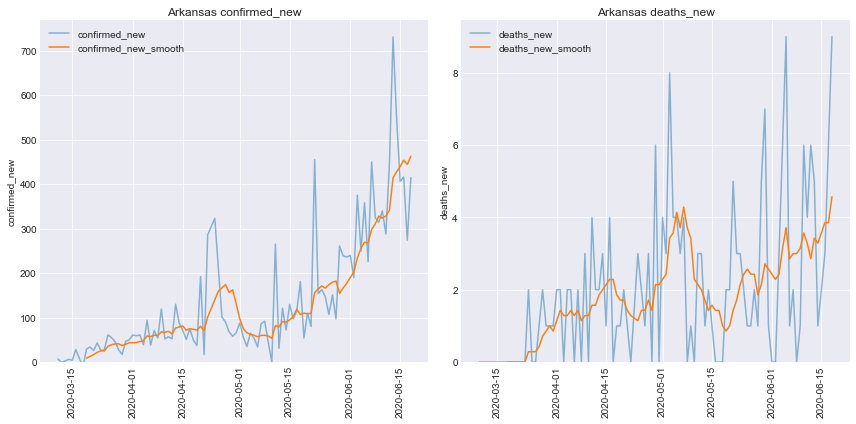

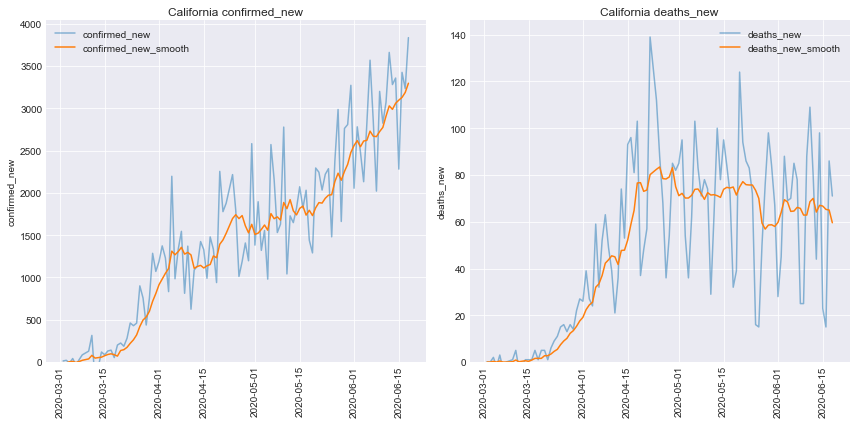

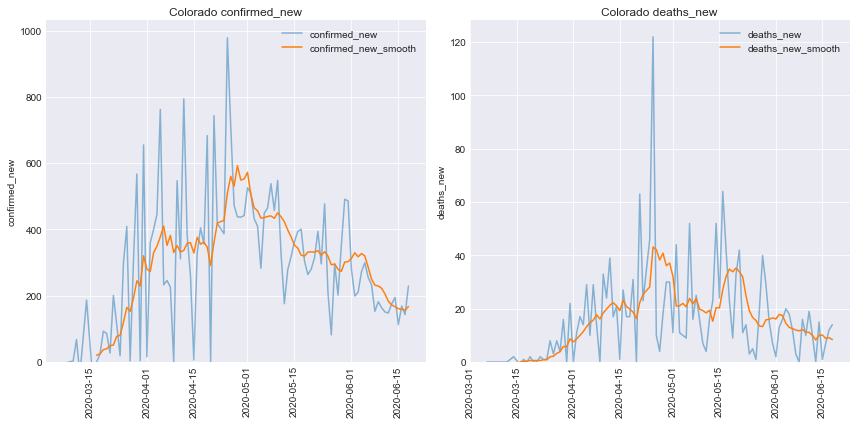

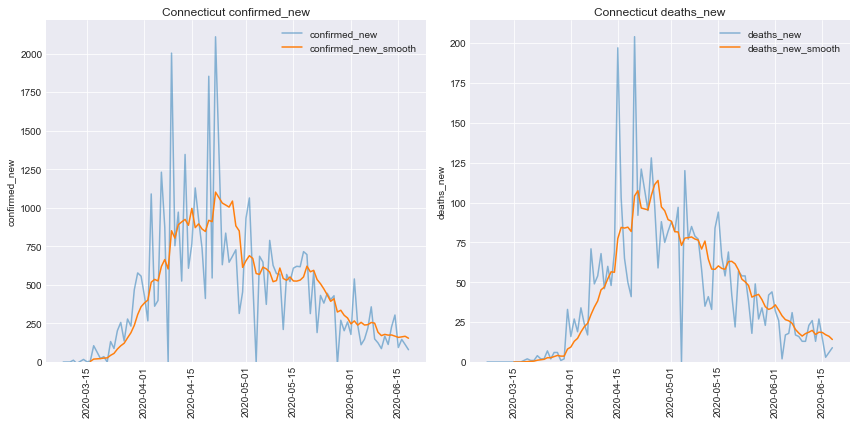

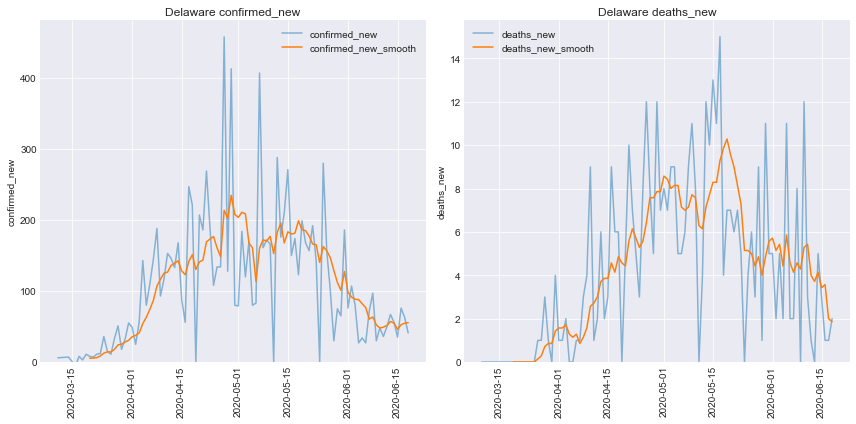

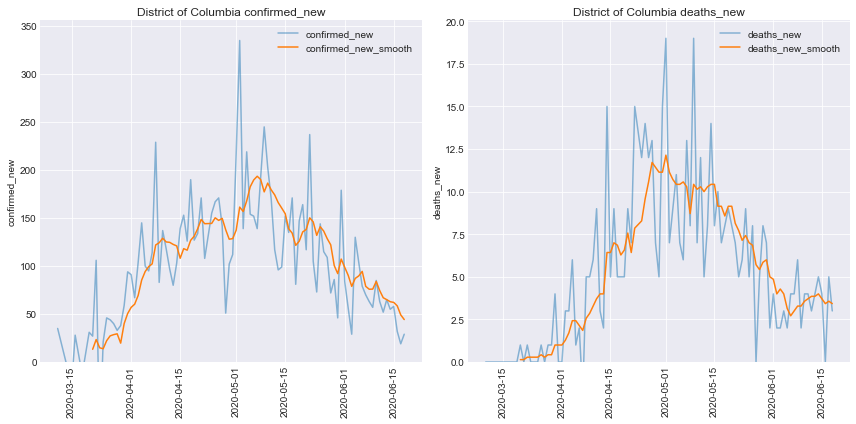

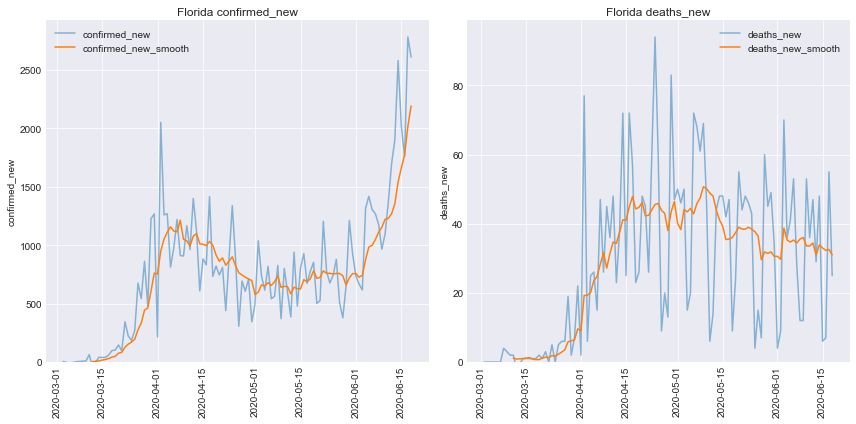

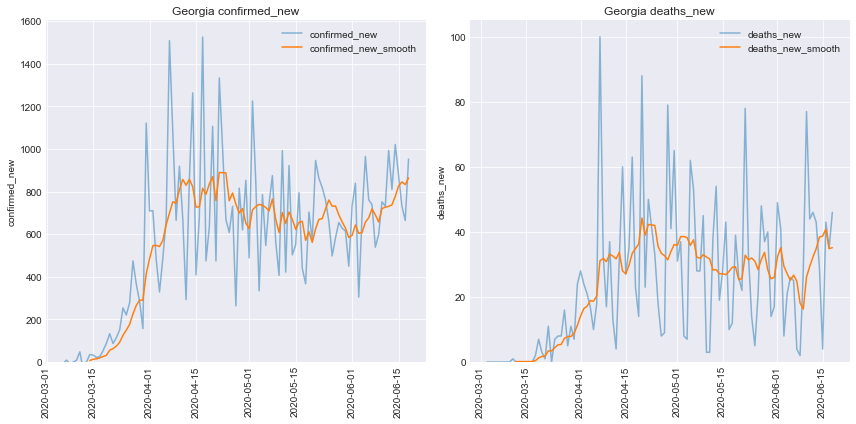

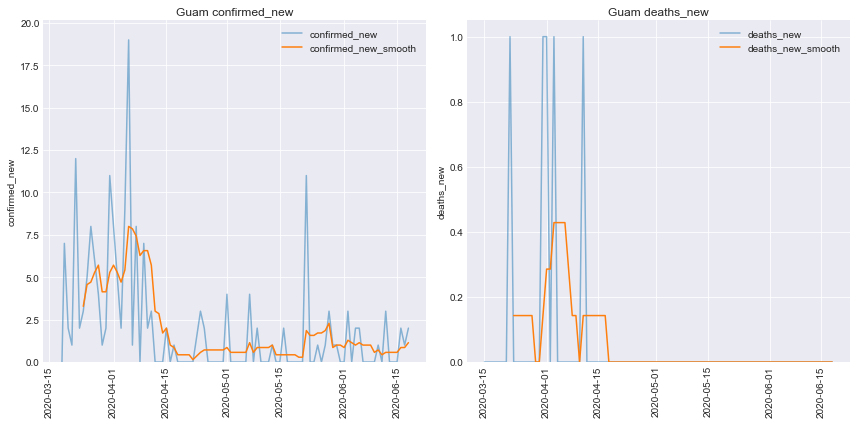

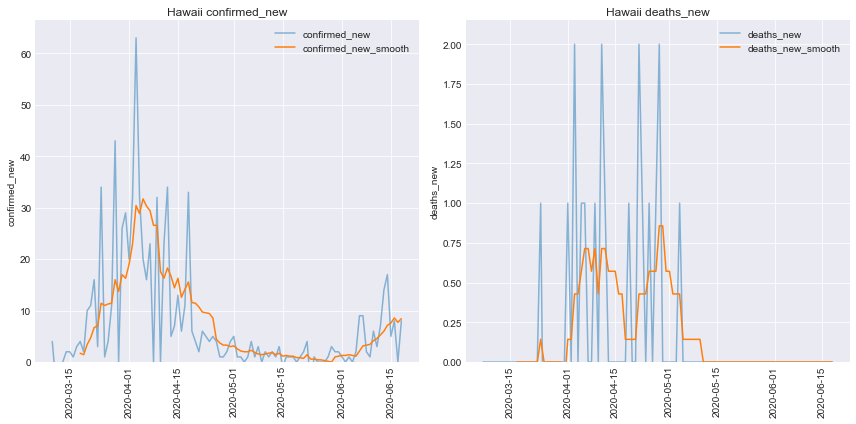

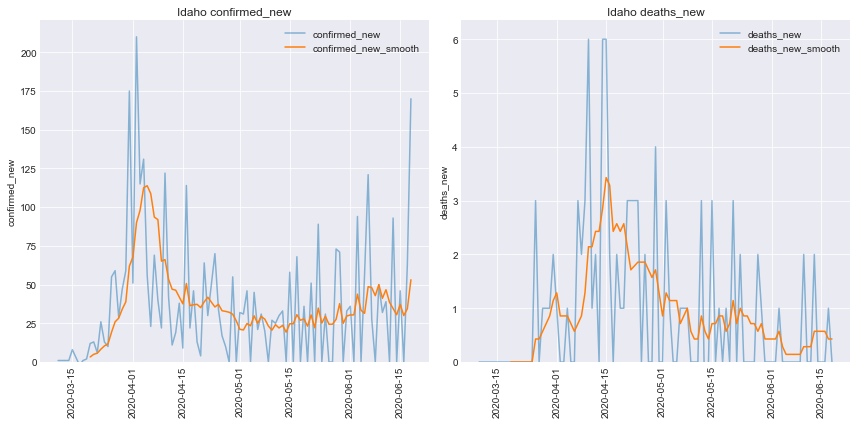

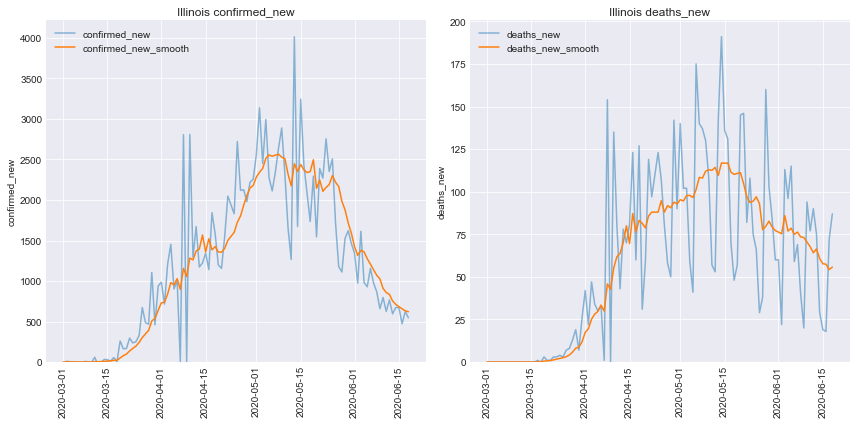

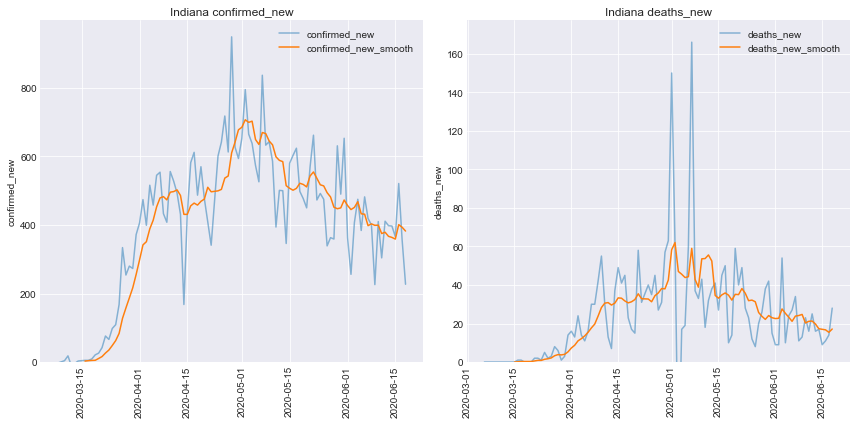

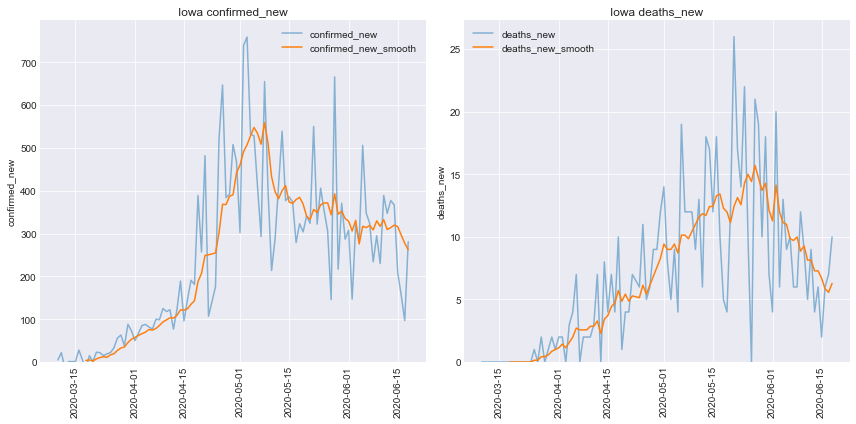

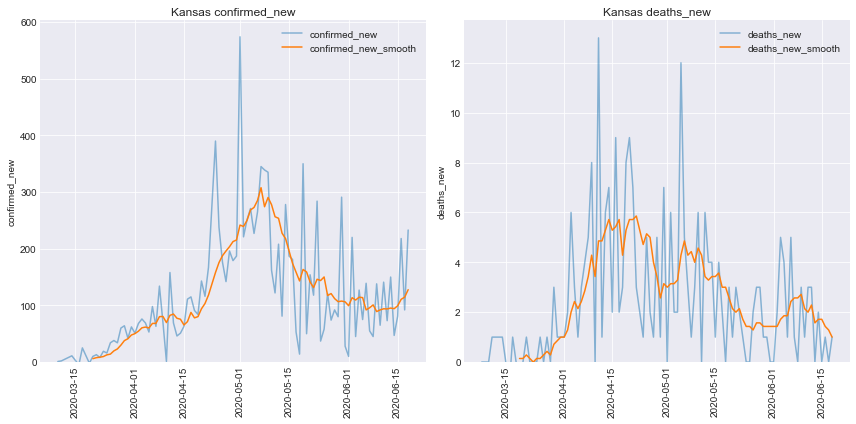

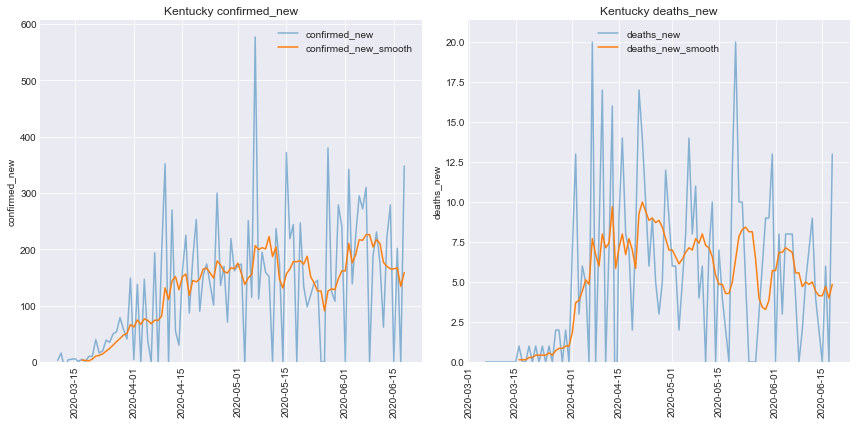

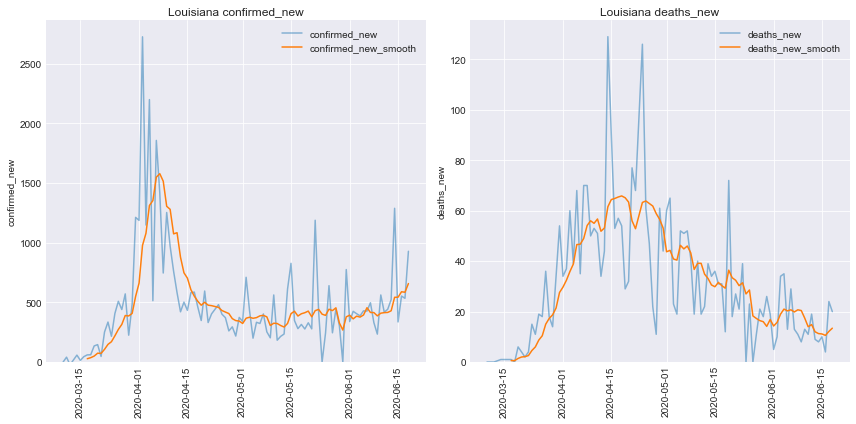

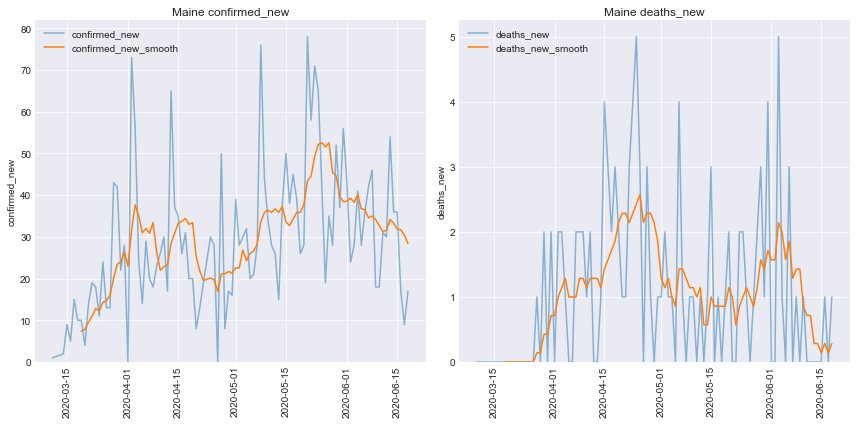

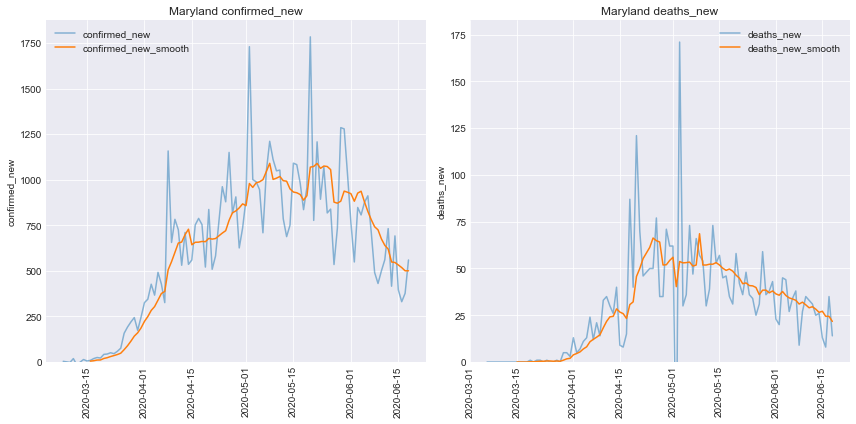

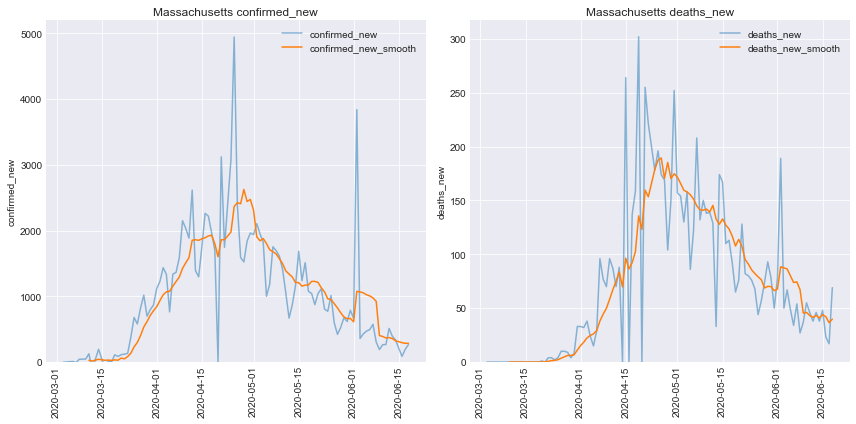

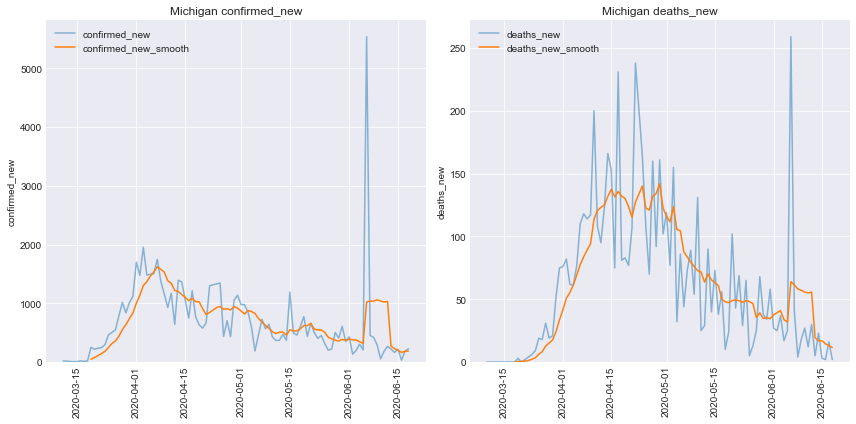

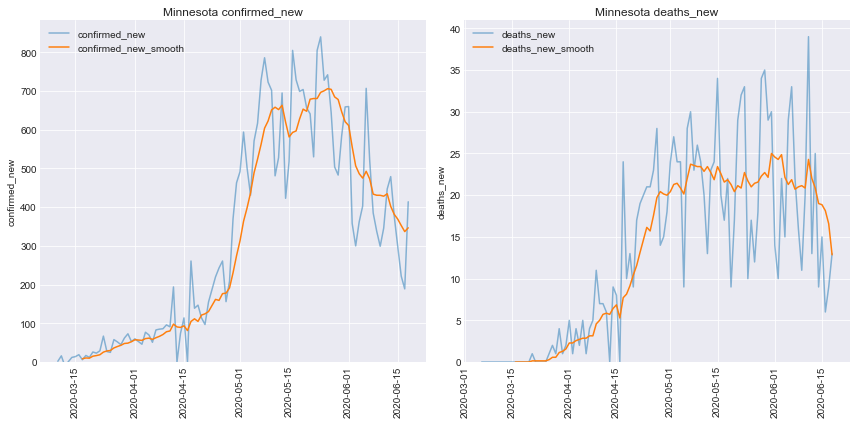

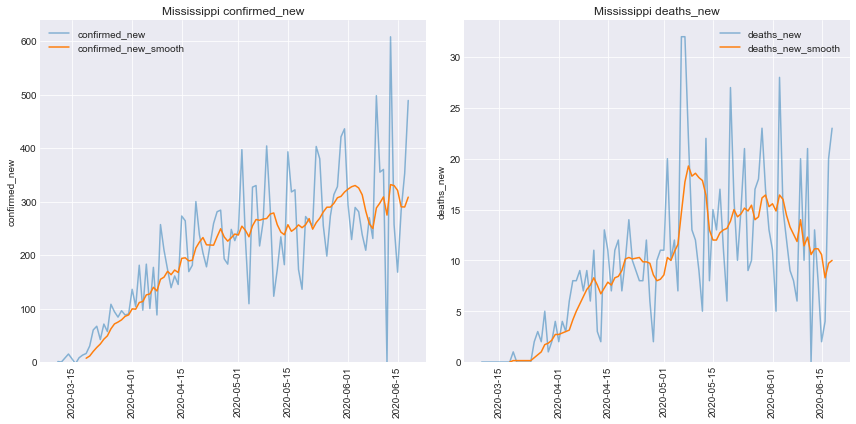

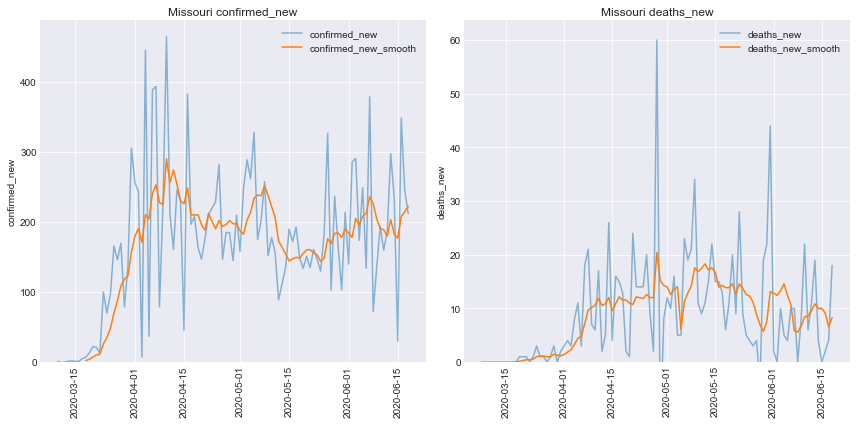

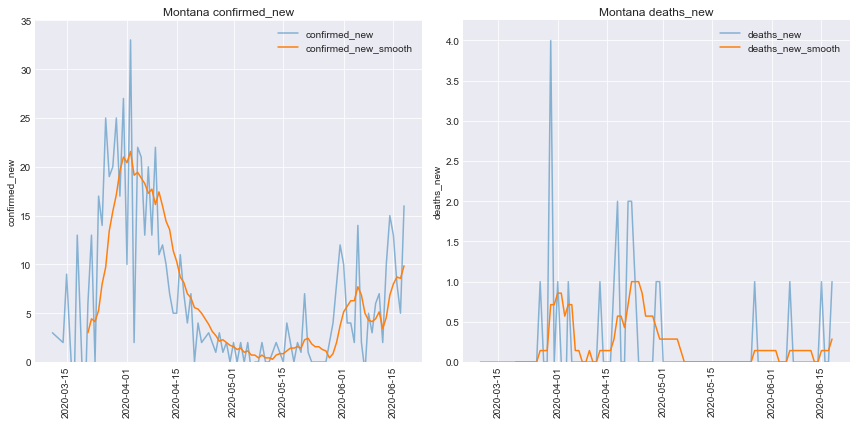

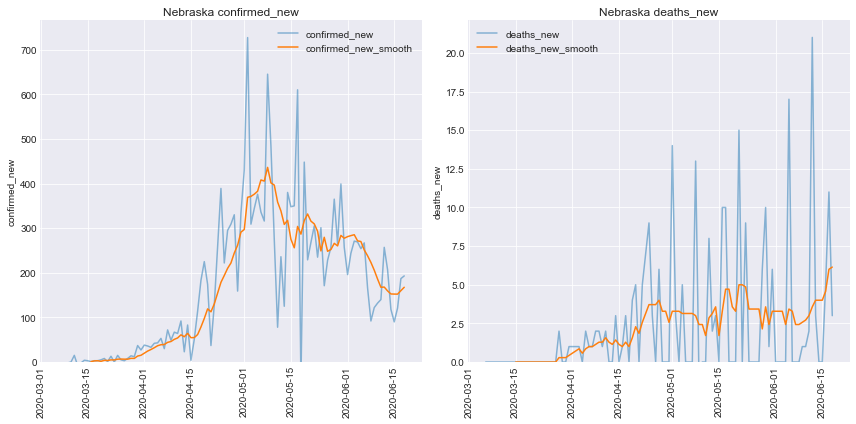

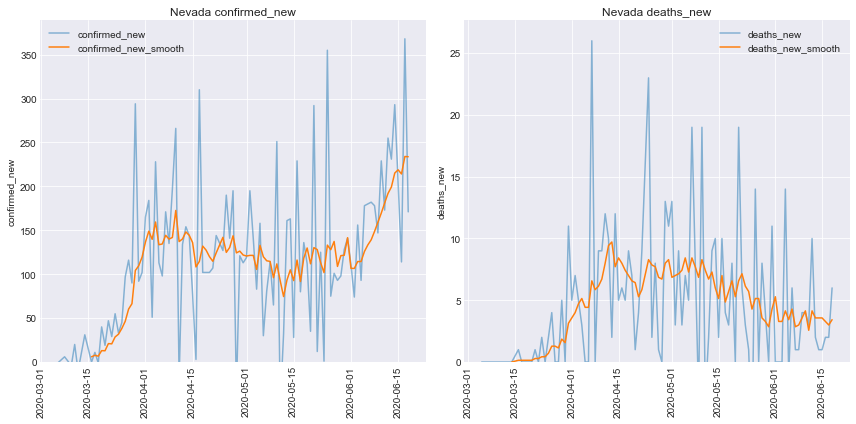

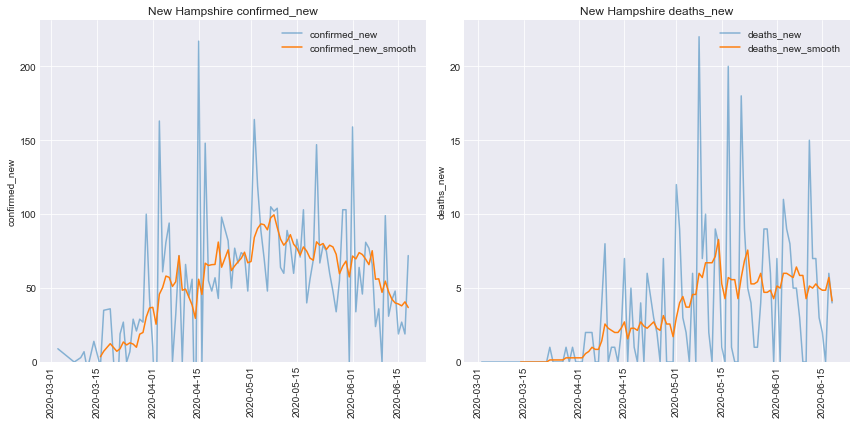

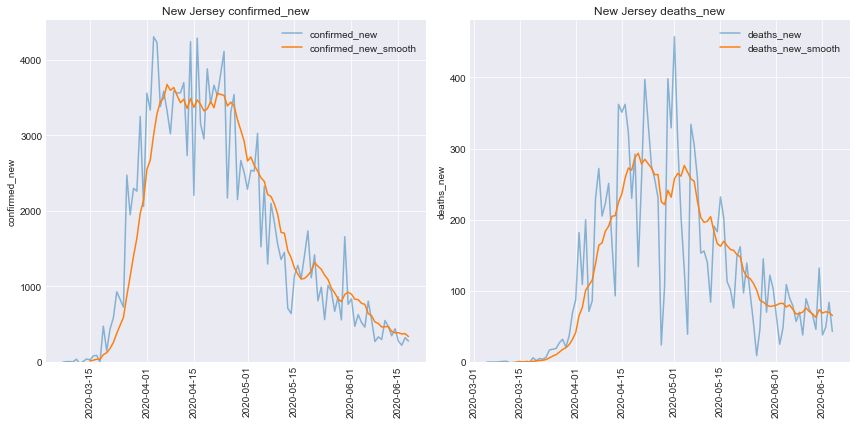

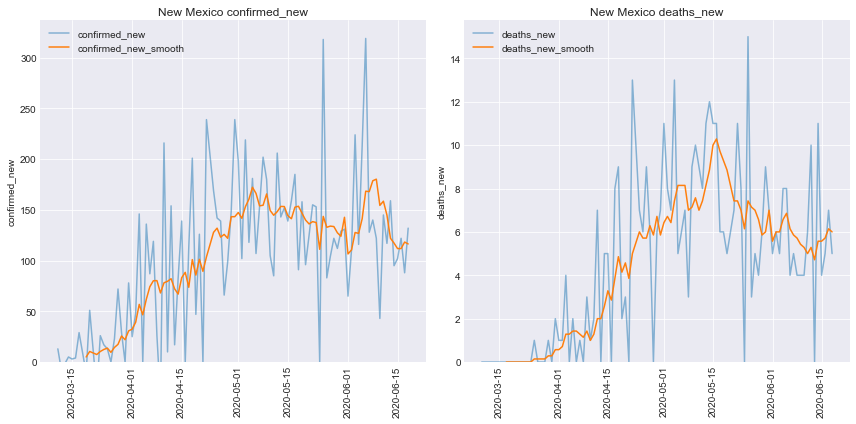

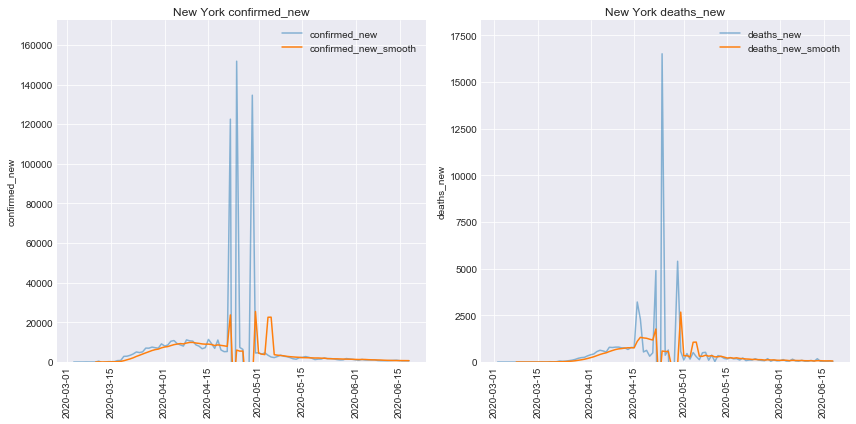

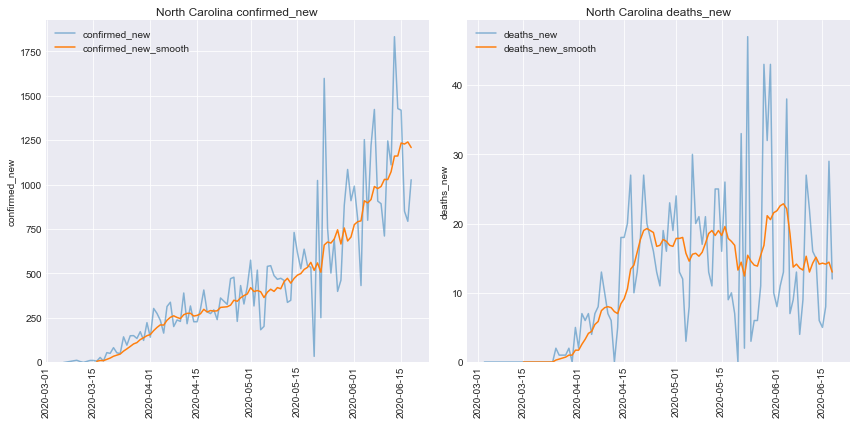

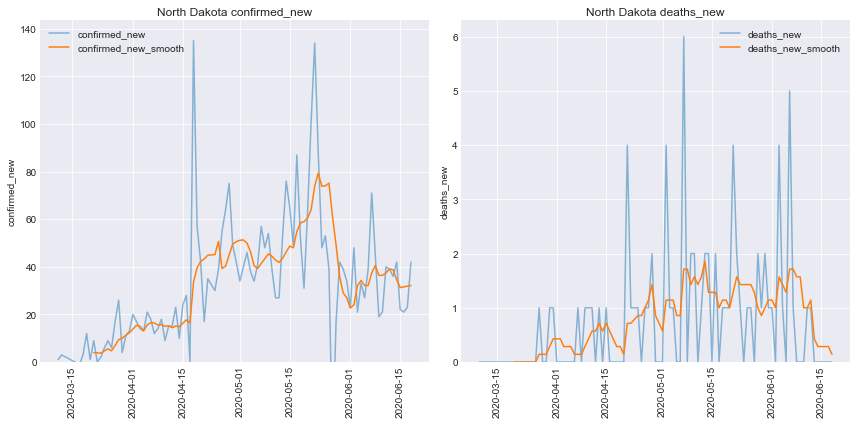

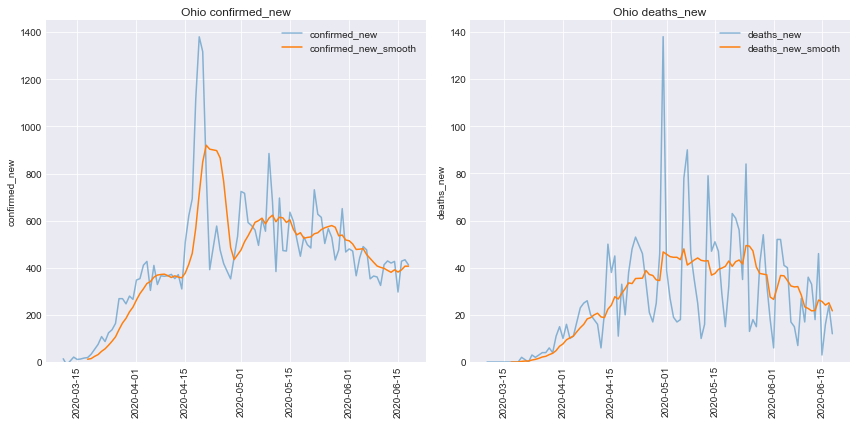

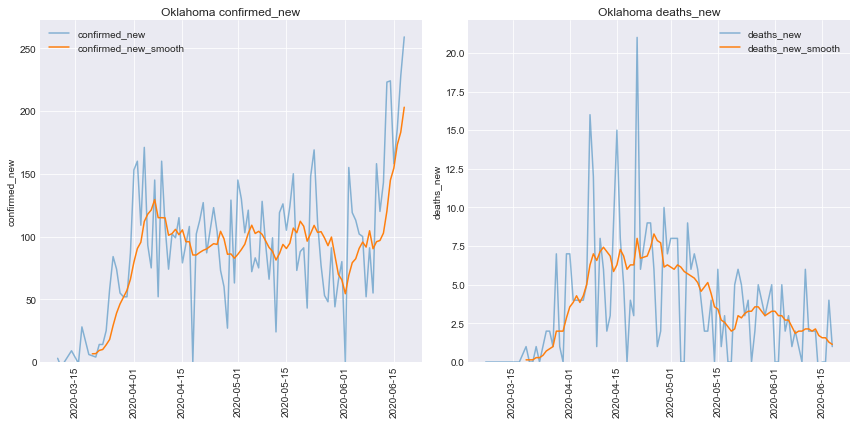

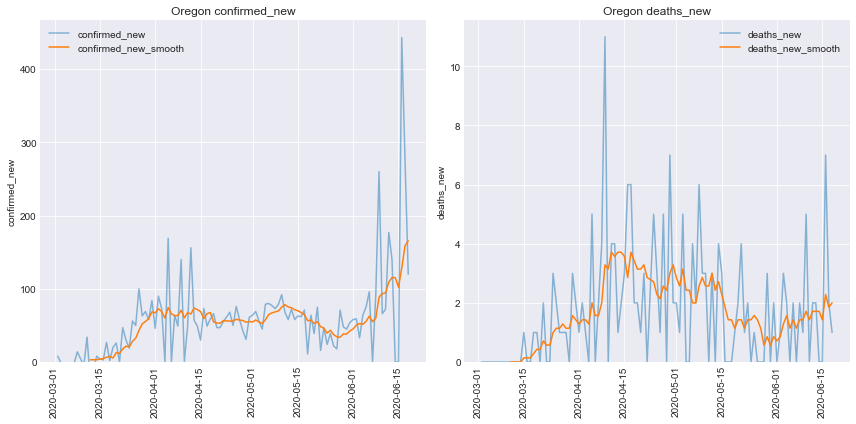

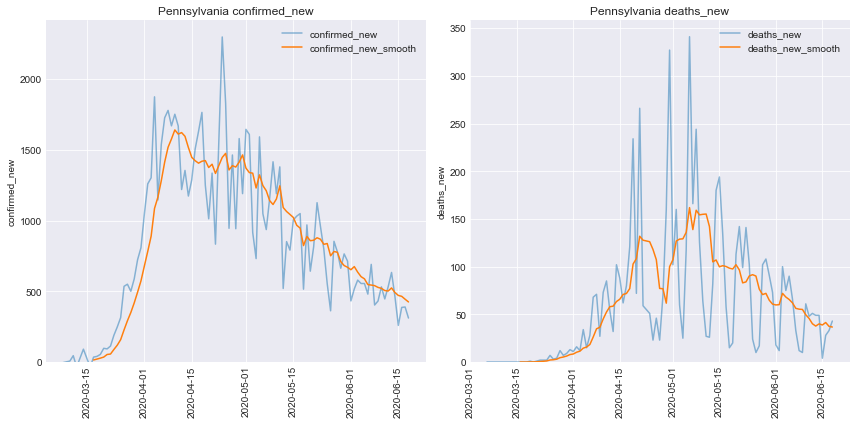

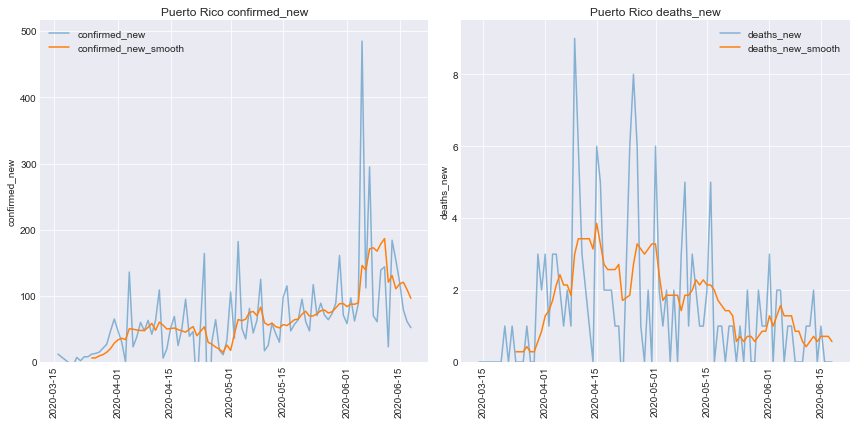

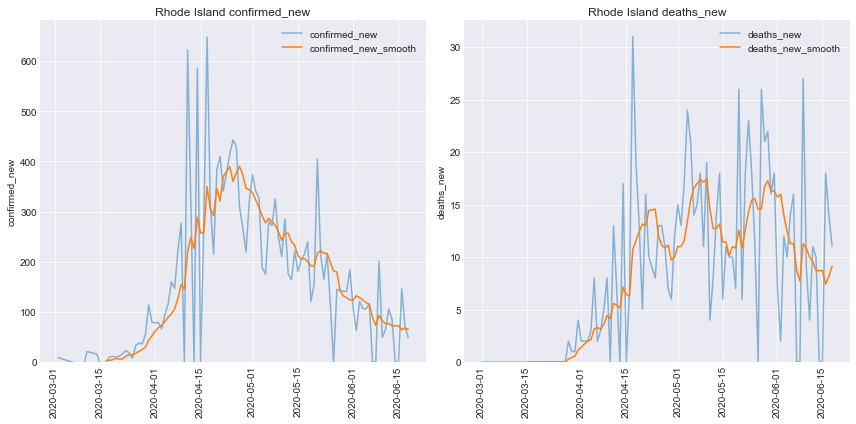

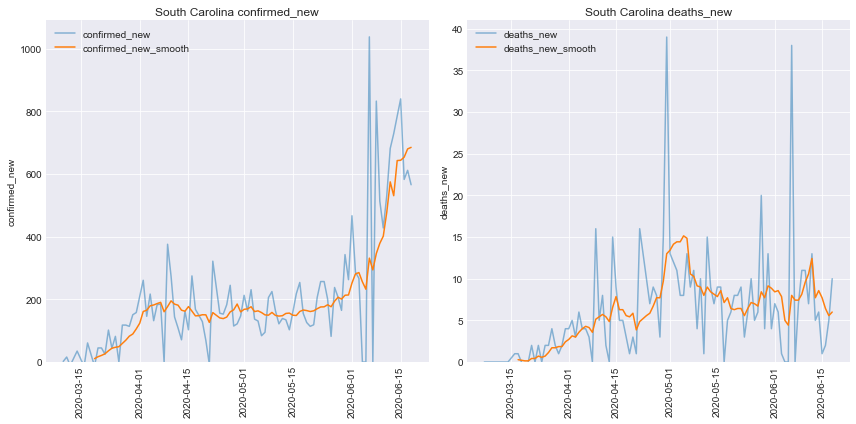

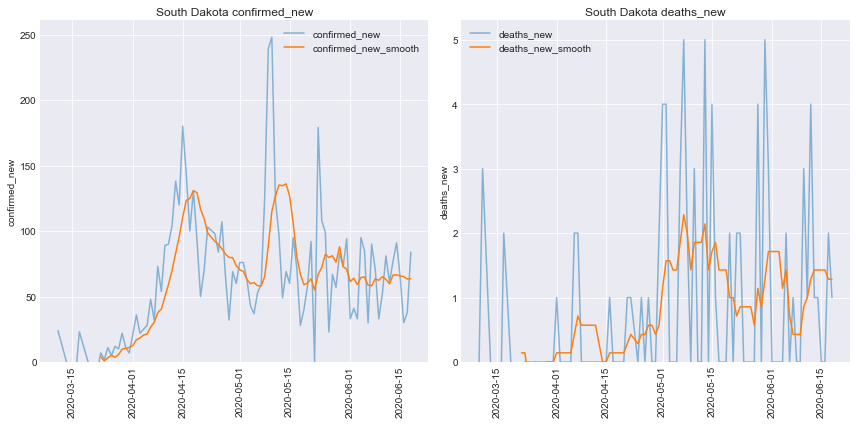

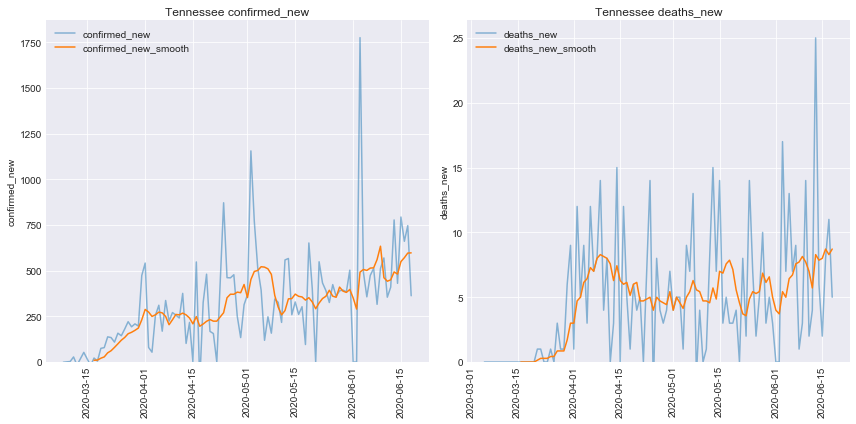

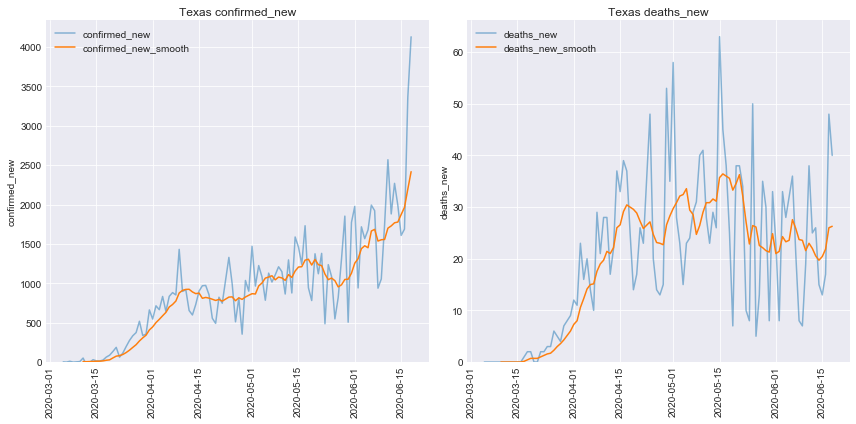

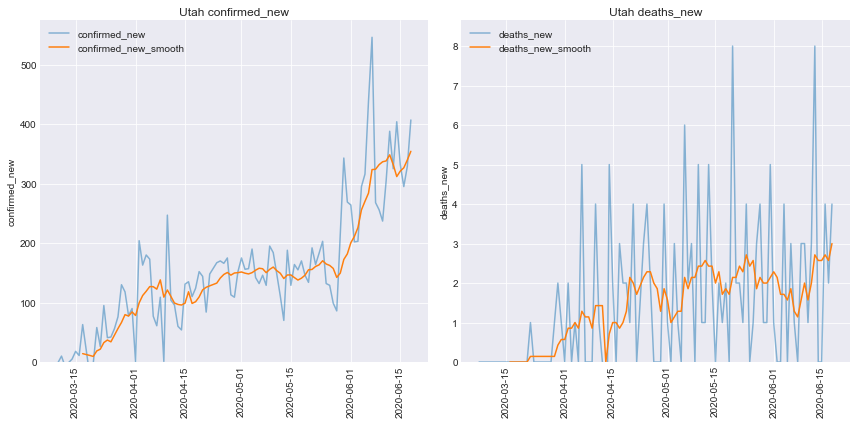

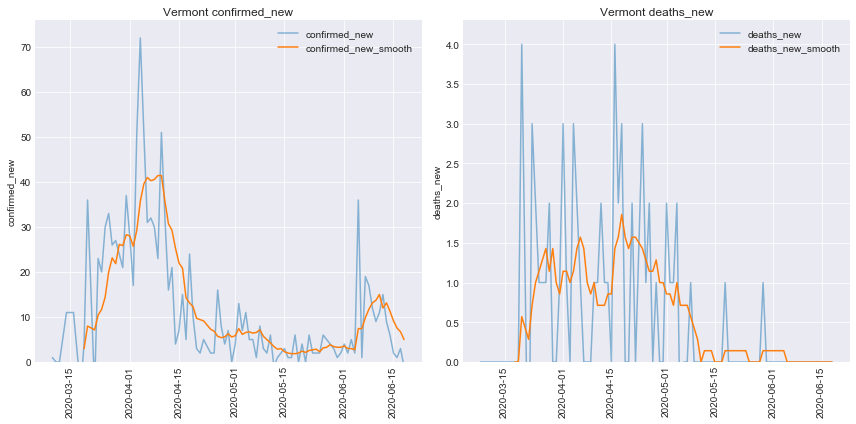

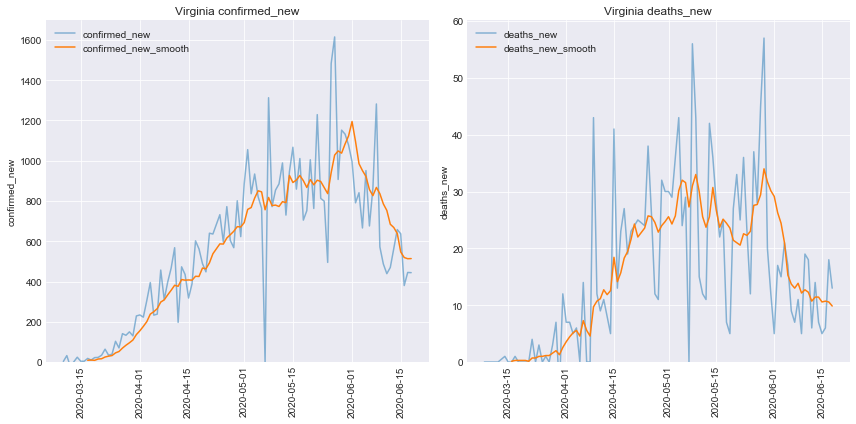

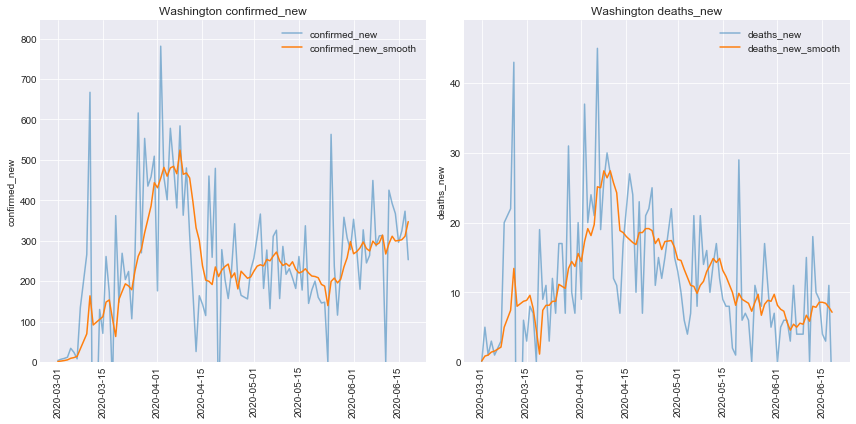

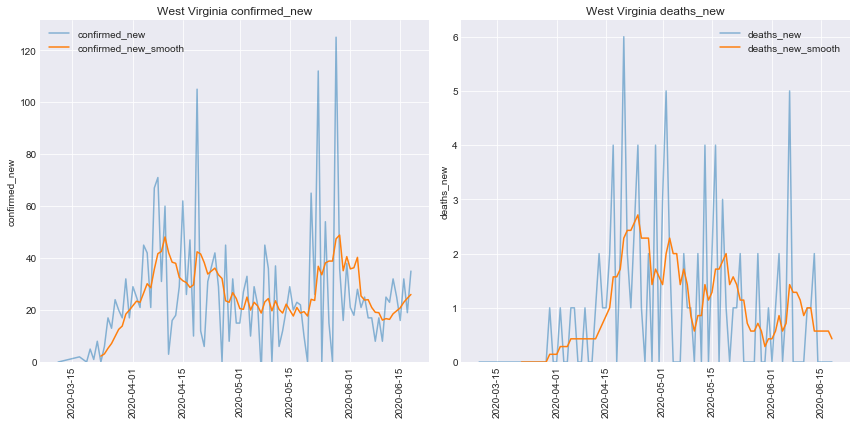

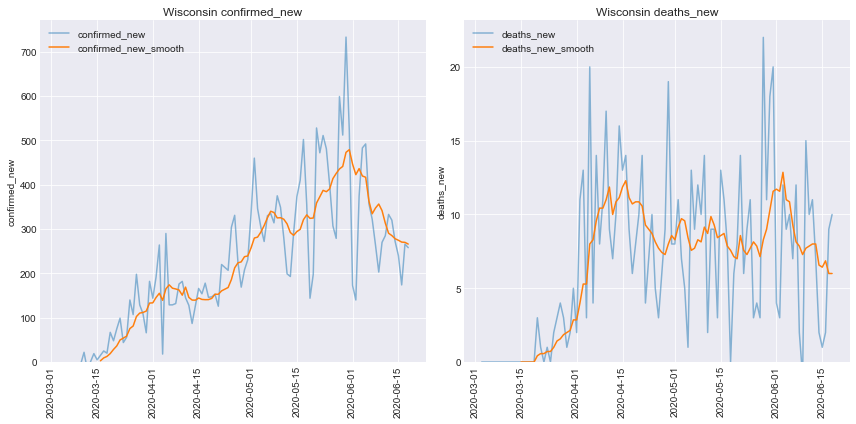

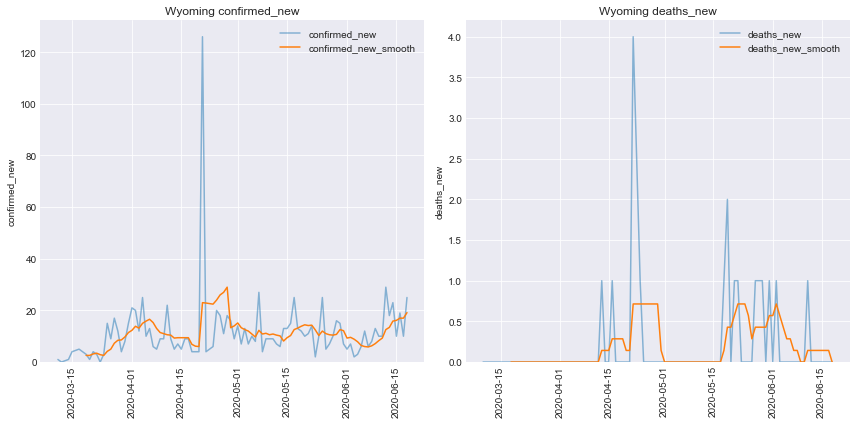

In [1040]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [1041]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                  Tennessee              0.029824                 0.021777
1                   Nebraska              0.027065                -0.037429
2                   Arkansas              0.026752                 0.057153
3                       Utah              0.017541                 0.038697
4                    Arizona              0.017323                 0.073149
5                    Georgia              0.015612                 0.018011
6                     Oregon              0.015334                 0.076469
7                     Kansas              0.004773                -0.000736
8               North Dakota              0.003948                 0.009863
9                 California              0.003720                 0.016336
10                   Florida              0.000587                 0.058511
11                     Texas              0.000442                 0.034268
12                   Montana              0.000000                 0.031378
13                 Recovered              0.000000                 0.000000
14                   Vermont              0.000000                 0.064829
15            Virgin Islands              0.000000                 0.000000
16                    Alaska              0.000000                 0.066436
17                   Wyoming              0.000000                 0.031686
18                     Idaho              0.000000                 0.010555
19          Diamond Princess              0.000000                 0.000000
20            Grand Princess              0.000000                 0.000000
21                      Guam              0.000000                -0.000917
22                    Hawaii              0.000000                 0.100169
23  Northern Mariana Islands             -0.000090                 0.000000
24                Washington             -0.000183                 0.009917
25             West Virginia             -0.000427                -0.037090
26               Puerto Rico             -0.001042                 0.018742
27             New Hampshire             -0.002140                -0.034854
28                   Alabama             -0.002467                 0.027576
29                     Maine             -0.003348                -0.016757
30            South Carolina             -0.004591                 0.070278
31                    Nevada             -0.004917                 0.041850
32                New Mexico             -0.006493                -0.002644
33              South Dakota             -0.006889                -0.005152
34                  Missouri             -0.009918                 0.004036
35                New Jersey             -0.010098                -0.053191
36                  Kentucky             -0.010446                -0.000598
37      District of Columbia             -0.018594                -0.034411
38                 Minnesota             -0.019000                -0.032148
39                   Indiana             -0.019889                -0.012213
40                  Illinois             -0.020048                -0.054014
41                 Louisiana             -0.020176                 0.030338
42                      Ohio             -0.023031                -0.017966
43                  Maryland             -0.025285                -0.036253
44            North Carolina             -0.028094                 0.030712
45                  New York             -0.029519                -0.040107
46               Mississippi             -0.029590                -0.002304
47                 Wisconsin             -0.032933                -0.032066
48                  Delaware             -0.033576                -0.044442
49              Pennsylvania             -0.034598                -0.023610
50                  Colorado             -0.036950                -0.040685
51              Rhode Island             -0.038533                -0.04

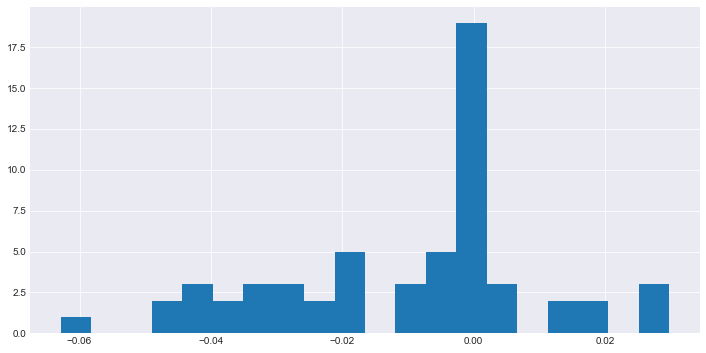

In [1042]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

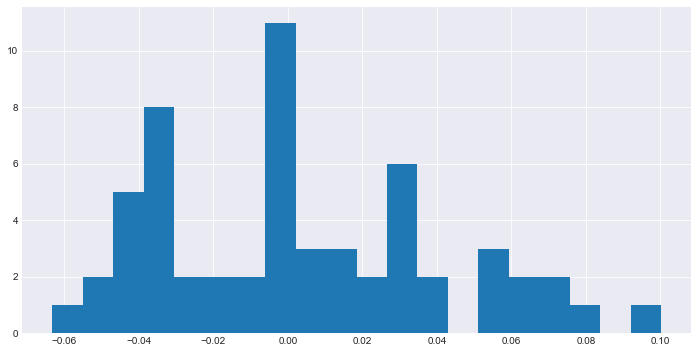

In [1043]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [1044]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0     Tennessee              0.029824                 0.021777
1      Nebraska              0.027065                -0.037429
2      Arkansas              0.026752                 0.057153
3          Utah              0.017541                 0.038697
4       Arizona              0.017323                 0.073149
5       Georgia              0.015612                 0.018011
6        Oregon              0.015334                 0.076469
7        Kansas              0.004773                -0.000736
8  North Dakota              0.003948                 0.009863
9    California              0.003720                 0.016336

### Which states are increasing in new deaths <u>least</u> quickly?

In [1045]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48       Delaware             -0.033576                -0.044442
49   Pennsylvania             -0.034598                -0.023610
50       Colorado             -0.036950                -0.040685
51   Rhode Island             -0.038533                -0.040867
52  Massachusetts             -0.041368                -0.063281
53    Connecticut             -0.043634                -0.036188
54           Iowa             -0.043925                -0.007120
55       Oklahoma             -0.045410                 0.053488
56       Michigan             -0.048104                -0.027152
57       Virginia             -0.062878                -0.041521

### Is there a day-of-the-week effect on new deaths?

In [1046]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [1047]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [1048]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -4.333333        -0.619048    2.666667   
379  Washington    1    -3.000000        -0.428571    4.000000   
380  Washington    2     3.666667         0.523810   10.666667   
381  Washington    3    -6.666667        -0.952381    0.333333   
382  Washington    4     3.666667         0.523810   10.666667   
383  Washington    5     1.666667         0.238095    8.666667   
384  Washington    6    -0.333333        -0.047619    6.666667   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                     7.0        22.333333             0.085109  
379                     7.0        11.333333             0.038222  
380                     7.0        -6.666667            -0.034686  
381                     7.0      -105.000000            -0.343546  
382                     7.0        62.000000             0.219360  
383                     7.0        37.666667             0.129823  
384                     7.0        78.333333             0.270158

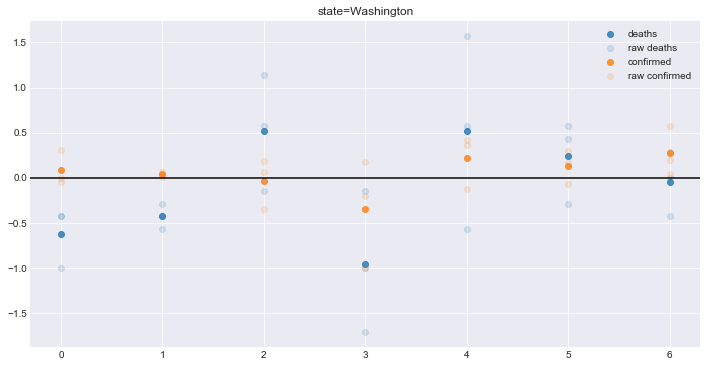

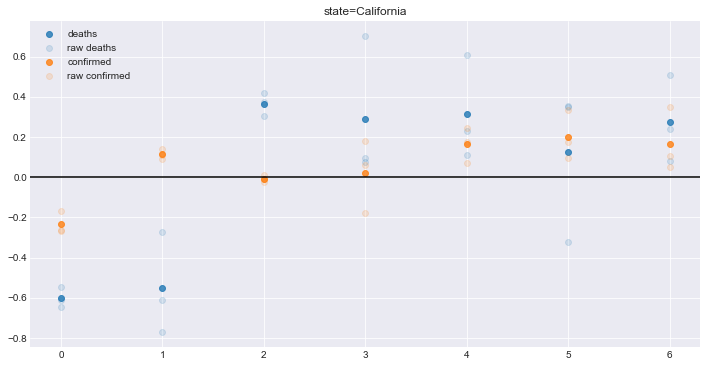

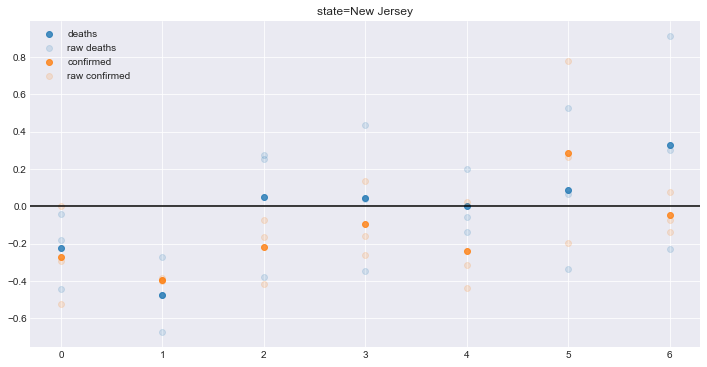

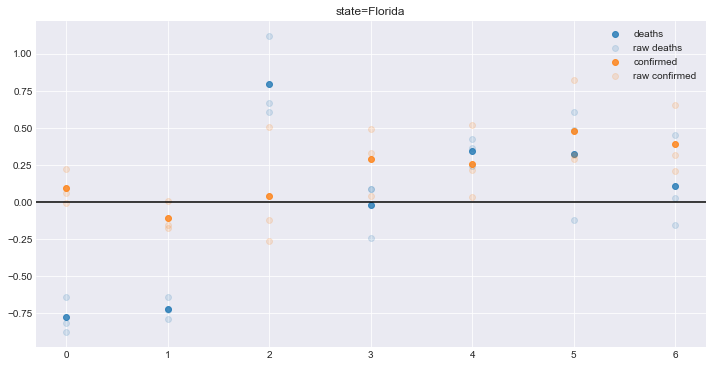

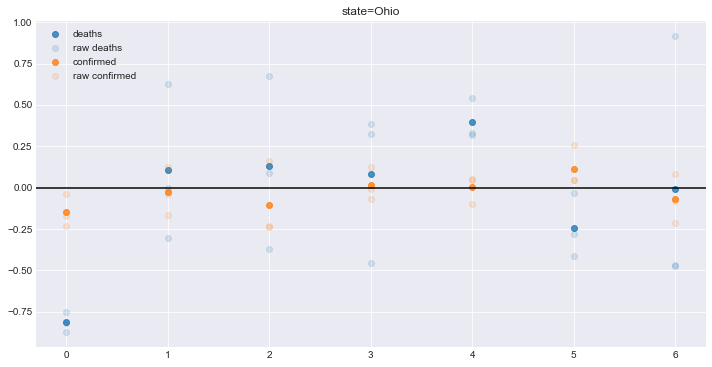

In [1049]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()